# Base Uniswap actively traded ATH index

- Version 3 of this strategy with yield farming component
- ATL filter added

# Set up

Set up Trading Strategy data client.


In [1]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode, set_notebook_logging

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


logger = logging.getLogger("strategy")



Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Chain and validation test configuration

- Configure different chain parameters and allow fast switching between them
- This allows us to easily do backtest validation with data from different chains
- Each chain comes with different exchanges and different TVL depths we need to trade against,
  this cannot be automatically detected

In [2]:
from eth_defi.token import USDC_NATIVE_TOKEN
from eth_defi.token import USDT_NATIVE_TOKEN
from eth_defi.token import WRAPPED_NATIVE_TOKEN

from tradingstrategy.chain import ChainId
from tradingstrategy.lending import LendingProtocolType

CHAIN_ID = ChainId.base


# We define our main trading universe,
# and then Ethereum mainnet as a validation set
match CHAIN_ID:

    case ChainId.base:

        EXCHANGES = ("uniswap-v2", "uniswap-v3",)

        SUPPORTING_PAIRS = [
            (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030),  
            (ChainId.base, "uniswap-v3", "cbBTC", "WETH", 0.0030),    # Only trading since October
        ]

        EXAMINED_ASSETS = [
            "AIXBT", 
            "PEPE",
            "KEYCAT",
            "WETH",
            "cbBTC"
        ]

        VOL_PAIR = (CHAIN_ID, "uniswap-v2", "WETH", "USDC", 0.0030)

        #: Needed for USDC credit
        LENDING_RESERVES  = [
            (CHAIN_ID, LendingProtocolType.aave_v3, "USDC"),
        ]    

        PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[CHAIN_ID].lower()

        VAULTS = [

            # Harvest USDC Autopilot on Bas

            # Harvest USDC Autopilot on IPOR on Base
            # https://app.ipor.io/fusion/base/0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4
            (ChainId.base, "0x0d877Dc7C8Fa3aD980DfDb18B48eC9F8768359C4".lower()),

            # maxAPY USDC base
            # https://app.maxapy.io/vaults/super/usdc
            (ChainId.base, "0x7a63e8fc1d0a5e9be52f05817e8c49d9e2d6efae".lower()),

            # Morpho
            # Morpho Moonwell Flagship USDC Compounder
            (ChainId.base, "0xd5428b889621eee8060fc105aa0ab0fa2e344468".lower()),

            # Spark
            # Spark USDC Vault	
            (ChainId.base, "0x7bfa7c4f149e7415b73bdedfe609237e29cbf34a".lower()),
        ]

        MIN_TVL = 170_000
        MIN_VOLUME = 25_000
    
    case ChainId.ethereum:

        EXCHANGES = ("uniswap-v2", "uniswap-v3", "sushi")

        SUPPORTING_PAIRS = [
            (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030),  
            (ChainId.ethereum, "uniswap-v3", "WBTC", "USDC", 0.0030),    # Only trading since October
        ]

        EXAMINED_ASSETS = [
            "PEPE",
            "AAVE",
            "WETH",
            "WBTC",
        ]

        VOL_PAIR = (Parameters.chain_id, "uniswap-v3", "WBTC", "USDC", 0.0030)

        #: Needed for USDC credit
        LENDING_RESERVES  = [
            (Parameters.chain_id, LendingProtocolType.aave_v3, "USDC"),
        ]    

        PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[Parameters.chain_id.value].lower()


    case ChainId.binance:
        SUPPORTING_PAIRS = [
            (ChainId.binance, "pancakeswap-v2", "WBNB", "USDT", 0.0025),  
            (ChainId.binance, "pancakeswap-v2", "ETH", "WBNB", 0.0025),    # Only trading since October
        ]

        EXAMINED_ASSETS = [
            "WBNB",
            "FTC",
            "TRUNK",
            "CUMMIES",
        ]

        VOL_PAIR = (Parameters.chain_id, "pancakeswap-v2", "WBNB", "USDT", 0.0025)

        LENDING_RESERVES = None

        PREFERRED_STABLECOIN = USDT_NATIVE_TOKEN[Parameters.chain_id.value].lower()

        MIN_TVL = 500_000
        MIN_VOLUME = 25_000

    case ChainId.avalanche:
        SUPPORTING_PAIRS = [
            (ChainId.avalanche, "trader-joe", "WAVAX", "USDT.e", 0.0030),  
            (ChainId.avalanche, "trader-joe", "WETH.e", "WAVAX", 0.0030),    # Only trading since October
        ]

        EXAMINED_ASSETS = [
            "WAVAX",
            "JOE",
            "WETH.e",
        ]

        VOL_PAIR = (ChainId.avalanche, "trader-joe", "WAVAX", "USDT.e", 0.0030)

        PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[Parameters.chain_id.value].lower()

        LENDING_RESERVES = None    

    case _:
        raise NotImplementedError(f"Chain not supported: {CHAIN_ID}")

# Parameters

- Collection of parameters used in the calculations

In [3]:
import datetime

import pandas as pd


from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting
from tradeexecutor.utils.jupyter_notebook_name import get_notebook_id


class Parameters:

    id = get_notebook_id(globals())

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_4h
    
    # Coingecko categories to include
    #s
    # See list here: TODO
    #
    chain_id = CHAIN_ID
    exchanges = EXCHANGES
    
 
    #
    # Basket size, risk and balancing parametrs.
    #   
    min_asset_universe = 5  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 10  # How many assets our basket can hold once
    allocation = 0.95  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 500.0  # Don't make buys less than this amount
    sell_rebalance_min_threshold = 100.0
    sell_threshold = 0.05  # Sell if asset is more than 5% of the portfolio
    per_position_cap_of_pool = 0.0050  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.15 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0050  # Close position / do not open if weight is less than 50 BPS

    #
    # ATH indicator parameters.
    #
    # How we determine local ATH.
    #
    ath_delay_bars = 144
    ath_window_bars = 150
    ath_threshold = 1.10
    ath_span = 300

    #
    # Full ATH history filter parameters.
    #
    # Filter out bad tokens.
    #
    # If we are below 80% of all-time historical peak, never touch the token.
    #
    min_from_full_history_ath = 0.15   


    #
    # Volatility binning filter
    # vol_bin_filter = None disabled
    #
    vol_bin_filter = None
    vol_bin_filter_lookback = 180
    daily_atr_length = 20
    vol_bin_level_1_threshold = 0.25

    #
    # Basket inclusion criteria.
    #
    # For the length of trailing sharpe used in inclusion criteria
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_volatility_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    tvl_ewm_span = 7 * 24  # Smooth TVL inclusin criteria
    min_volume = MIN_VOLUME   # USD
    min_tvl_prefilter = MIN_TVL  # USD - to reduce number of trading pairs for backtest-purposes only
    min_tvl = MIN_TVL     # USD - set to same as above if you want to avoid any survivorship bias
    min_token_sniffer_score = 20  # 20 = AAVE


    #
    # Yield on cash
    #
    use_managed_yield = True
    yield_flow_dust_threshold = 5.0  # Min deposit USD to Aave
    directional_trade_yield_buffer_pct = 0.01  # For credit flow, assume we might get this less cash released from sells


    #     
    #
    # Backtesting only
    # Limiting factor: Aave v3 on Base starts at the end of DEC 2023
    #
    backtest_start = datetime.datetime(2024, 1, 1)
    backtest_end = datetime.datetime(2025, 8, 15)
    initial_cash = 100_000

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=365*3)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [4]:
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.client import Client
from tradingstrategy.client import Client

from tradingstrategy.utils.token_filter import add_base_quote_address_columns
from tradingstrategy.utils.token_filter import filter_for_exchange_slugs
from tradingstrategy.utils.token_filter import filter_pairs_default
from tradingstrategy.utils.token_extra_data import load_token_metadata
from tradingstrategy.utils.token_filter import filter_by_token_sniffer_score
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume


from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.analysis.pair import display_strategy_universe

from tradingstrategy.utils.token_extra_data import load_token_metadata
from tradingstrategy.utils.token_filter import filter_by_token_sniffer_score


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset

    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    if execution_context.live_trading:
        # Live trading, send strategy universe formation details 
        # to logs
        debug_printer = logger.info
    else:    
        # Notebook node
        debug_printer = print

    chain_id = Parameters.chain_id

    debug_printer(f"Preparing trading universe on chain {chain_id.get_name()}")

    exchange_universe = client.fetch_exchange_universe()
    targeted_exchanges = [exchange_universe.get_by_chain_and_slug(chain_id, slug) for slug in Parameters.exchanges]
    
    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    # TODO: PandasPairUniverse(buidl_index=True) - speed this up by skipping index building
    all_pairs_df = client.fetch_pair_universe().to_pandas()
    all_pairs_df = filter_for_exchange_slugs(all_pairs_df, Parameters.exchanges)
    debug_printer("Creating universe for benchmark pair extraction")
    pair_universe = PandasPairUniverse(
        all_pairs_df, 
        exchange_universe=exchange_universe,
        build_index=False,
    )
    debug_printer(f"Exchanges {Parameters.exchanges} have total {len(all_pairs_df):,} pairs on chain {Parameters.chain_id.get_name()}")

    # Get TVL data for prefilteirng
    if execution_context.live_trading:
        # For live trading, we take TVL data from ~around the start of the strategy until today
        tvl_time_bucket = TimeBucket.d1
        start = datetime.datetime(2024, 2, 1)
        end = tvl_time_bucket.floor(pd.Timestamp(datetime.datetime.utcnow() - tvl_time_bucket.to_timedelta()))
    else:
        start = Parameters.backtest_start
        end = Parameters.backtest_end

    #
    # Do exchange and TVL prefilter pass for the trading universe
    #
    min_tvl = Parameters.min_tvl_prefilter
    # logging.getLogger().setLevel(logging.INFO)
    liquidity_time_bucket = TimeBucket.d1
    tvl_df = client.fetch_tvl(
        mode="min_tvl_low",
        bucket=liquidity_time_bucket,
        start_time=start,
        end_time=end,
        exchange_ids=[exc.exchange_id for exc in targeted_exchanges],
        min_tvl=min_tvl,
    )
    # logging.getLogger().setLevel(logging.WARNING)
    debug_printer(f"Fetch TVL, we got {len(tvl_df['pair_id'].unique())} pairs with TVL data for min TVL criteria {min_tvl}")

    tvl_filtered_pair_ids = tvl_df["pair_id"].unique()
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]
    needed_pair_ids = set(benchmark_pair_ids) | set(tvl_filtered_pair_ids)
    pairs_df = all_pairs_df[all_pairs_df["pair_id"].isin(needed_pair_ids)]
    debug_printer(f"After TVL prefilter to {Parameters.min_tvl_prefilter:,} in {Parameters.backtest_start} - {Parameters.backtest_end}, we have {len(pairs_df)} trading pairs")
    pairs_df = add_base_quote_address_columns(pairs_df)

    # Never deduplicate supporting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]

    allowed_quotes = {
        PREFERRED_STABLECOIN,
        WRAPPED_NATIVE_TOKEN[chain_id.value].lower(),
    }
    filtered_pairs_df = filter_pairs_default(
        pairs_df,
        good_quote_token_addresses=allowed_quotes,
        verbose_print=print,
    )

    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(filtered_pairs_df)

    # Get our reference pairs back to the dataset
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')
    debug_printer(f"After deduplication we have {len(pairs_df)} pairs")

    # Add benchmark pairs back to the dataset
    pairs_df = pd.concat([pairs_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    # Load metadata
    debug_printer("Loading metadata")
    # logging.getLogger().setLevel(logging.INFO)
    pairs_df = load_token_metadata(pairs_df, client, printer=debug_printer)
    # logging.getLogger().setLevel(logging.WARNING)

    # Scam filter using TokenSniffer
    risk_filtered_pairs_df = filter_by_token_sniffer_score(
        pairs_df,
        risk_score=Parameters.min_token_sniffer_score,
        printer=debug_printer,
    )

    # Check if we accidentally get rid of benchmark pairs we need for the strategy
    difference = set(benchmark_pair_ids).difference(set(risk_filtered_pairs_df["pair_id"]))
    if difference:
        first_dropped_id = next(iter(difference))
        first_dropped_data = pairs_df.loc[pairs_df.pair_id == first_dropped_id]
        assert len(first_dropped_data) == 1, f"Got {len(first_dropped_data)} entries: {first_dropped_data}"
        raise AssertionError(f"Benchmark trading pair dropped in filter_by_token_sniffer_score() check: {first_dropped_data.iloc[0]}")
    pairs_df = risk_filtered_pairs_df.sort_values("volume", ascending=False)
    debug_printer(f"After TokenSniffer risk filter we have {len(pairs_df)} pairs")

    # Remove extra pairs from the TVL data,
    # so we do not drag extra data and memory usage to the trading universe and liquidity candles
    tvl_pair_count_no_filtering = tvl_df["pair_id"].nunique()
    tvl_df = tvl_df[tvl_df["pair_id"].isin(pairs_df["pair_id"])]
    tvl_filtering_count = tvl_df["pair_id"].nunique()
    debug_printer(f"TVL data before risk filtering had {tvl_pair_count_no_filtering} pairs, after filtering we have {tvl_filtering_count} pairs")

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    other_dex = pairs_df.loc[~((pairs_df["exchange_slug"] != "uniswap-v3") | (pairs_df["exchange_slug"] != "uniswap-v2"))]
    debug_printer(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}, other DEX: {len(other_dex)}")
    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity_time_bucket=liquidity_time_bucket,
        preloaded_tvl_df=tvl_df,
        lending_reserves=LENDING_RESERVES,    
        vaults=VAULTS,
        vault_bundled_price_data=True,
    )

    reserve_asset = PREFERRED_STABLECOIN
    
    debug_printer("Creating trading universe")
    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset=reserve_asset,
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
        forward_fill_until=timestamp,
    )

    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = False

    debug_printer(f"Total {strategy_universe.get_pair_count()}")

    return strategy_universe

strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)

print("Universe creation done")

display_strategy_universe(
    strategy_universe, 
    sort_key="base",
    sort_numeric=False,
    limit=20,
)


Preparing trading universe on chain Base
Creating universe for benchmark pair extraction
Exchanges ('uniswap-v2', 'uniswap-v3') have total 169,925 pairs on chain Base
Fetch TVL, we got 527 pairs with TVL data for min TVL criteria 170000
After TVL prefilter to 170,000 in 2024-01-01 00:00:00 - 2025-08-15 00:00:00, we have 455 trading pairs
Pairs in the input dataset 455
Pairs having a good fee 455
Pairs that are not stable-stable 454
Pairs that are not derivative tokens 451
Pairs that are not rebase tokens 448
Pairs with good quote token 447
Pairs with clean ASCII token name 446
After deduplication we have 398 pairs
Loading metadata
Loading metadata for 397 base tokens in 398 trading pairs
Got data back for 397 tokens
TokenSniffer has 0 error entries
filter_by_token_sniffer_score(): total 398, missing metadata 0, missing TokenSniffer data 0, TokenSniffer error'ed: 0
Filtered by TokenSniffer risk score: 20, before: 398, after NA: 398, after risk score: 347, entries below threshold: 53, ze

Creating trading universe


/Users/moo/code/trade-executor/deps/trading-strategy/tradingstrategy/utils/wrangle.py:250: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Total 335
Universe creation done
Results limited to first 20 entries


base quote    exchange    type  fee %        price  \
id                                                               
4914060  $33BITS  WETH  uniswap-v3  traded    1.0         0.00   
4948317   $LARRY  WETH  uniswap-v3  traded    1.0         0.00   
4968456    $OTTO  WETH  uniswap-v3  traded    0.3         0.00   
3848055   $SHAKA  WETH  uniswap-v2  traded    0.3  <not avail>   
4621956  $STREET  WETH  uniswap-v3  traded    1.0         0.00   
4632783    $blue  WETH  uniswap-v3  traded    1.0         0.00   
4622192    $mfer  WETH  uniswap-v3  traded    1.0         0.01   
3779954    $poop  WETH  uniswap-v2  traded    0.3         0.00   
4831033    11:11  WETH  uniswap-v3  traded    1.0         0.00   
5713148      A0T  WETH  uniswap-v3  traded    1.0         1.90   
5200620      A1C  WETH  uniswap-v2  traded    0.3         0.39   
5326499      ABX  WETH  uniswap-v3  traded    0.3         0.00   
5098212    AEGNT  USDC  uniswap-v2  traded    0.3         0.00   
3998441  AEROBUD  WETH  uniswap-v2  traded    0.3         0.01   
4486026    AGENT  USDC  uniswap-v2  traded    0.3         0.00   
4887842     AGNT  USDC  uniswap-v2  traded    0.3         0.00   
4680196      AIM  USDC  uniswap-v3  traded    1.0         0.01   
4995281     AION  WETH  uniswap-v2  traded    0.3         0.19   
5110569     AIOS  WETH  uniswap-v2  traded    0.3         0.00   
4647244  AIRDROP  WETH  uniswap-v3  traded    1.0         0.00   

            last_price_at       first_price_at   volume        tvl  tvl_at  \
id                                                                           
4914060  14 days 13:00:00  2024-11-20 05:00:00     0.00     30,793 14 days   
4948317  15 days 11:00:00  2024-12-05 04:00:00     0.00     65,036 14 days   
4968456  14 days 13:00:00  2024-12-09 14:00:00     0.00     19,756 14 days   
3848055                 -                    -     0.00          0 14 days   
4621956  14 days 22:00:00  2024-03-28 23:00:00     0.00     24,507 14 days   
4632783  14 days 15:00:00  2024-04-12 12:00:00     0.00        738 14 days   
4622192  14 days 13:00:00  2024-03-29 16:00:00     0.00    332,021 14 days   
3779954  14 days 23:00:00  2024-03-30 11:00:00     0.00     85,370 14 days   
4831033  16 days 07:00:00  2024-11-11 19:00:00     0.00    519,091 14 days   
5713148  14 days 13:00:00  2025-03-15 18:00:00     0.00    586,439 14 days   
5200620  14 days 19:00:00  2025-01-21 06:00:00     0.00    300,657 14 days   
5326499  14 days 12:00:00  2025-02-14 16:00:00  4107.18    261,122 14 days   
5098212  15 days 07:00:00  2025-01-01 16:00:00     0.00     50,970 14 days   
3998441  14 days 13:00:00  2024-05-25 23:00:00     0.00    382,147 14 days   
4486026  14 days 12:00:00  2024-09-19 05:00:00   255.20     31,751 14 days   
4887842  15 days 02:00:00  2024-11-28 05:00:00     0.00    513,305 14 days   
4680196  15 days 00:00:00  2024-07-22 15:00:00     0.00    137,162 14 days   
4995281  14 days 13:00:00  2024-12-13 15:00:00     0.00    241,667 14 days   
5110569  43 days 03:00:00  2025-01-07 20:00:00     0.00    187,053 14 days   
4647244  14 days 12:00:00  2024-05-10 19:00:00     0.53  5,811,706 14 days   

                 tax pfee mfee  
id                              
4914060  0.0% / 0.0%  NaN  NaN  
4948317  0.0% / 0.0%  NaN  NaN  
4968456  0.0% / 0.0%  NaN  NaN  
3848055        - / -  NaN  NaN  
4621956  0.0% / 0.0%  NaN  NaN  
4632783  0.0% / 0.0%  NaN  NaN  
4622192  0.0% / 0.0%  NaN  NaN  
3779954        - / -  NaN  NaN  
4831033  0.0% / 0.0%  NaN  NaN  
5713148  0.0% / 0.0%  NaN  NaN  
5200620        - / -  NaN  NaN  
5326499  0.0% / 0.0%  NaN  NaN  
5098212        - / -  NaN  NaN  
3998441        - / -  NaN  NaN  
4486026        - / -  NaN  NaN  
4887842        - / -  NaN  NaN  
4680196  0.0% / 0.0%  NaN  NaN  
4995281        - / -  NaN  NaN  
5110569        - / -  NaN  NaN  
4647244  0.0% / 0.0%  NaN  NaN

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [5]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 333 assets
Category trading pairs 335
Benchmark trading pairs 0


# Indicators

- Precalculate indicators used by the strategy

In [6]:
import pandas as pd
from IPython.display import HTML
import pandas_ta

from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSource
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry
from tradeexecutor.analysis.indicator import display_indicators
from tradingstrategy.utils.groupeduniverse import resample_candles


indicators = IndicatorRegistry()

empty_series = pd.Series([], index=pd.DatetimeIndex([]))


@indicators.define()
def local_ath(
    close: pd.Series, 
    ath_delay_bars: int,
    ath_window_bars: int,
) -> pd.Series:
    """All time high indicator.

    - Calculate % we are above all time high

    :param ath_window_bars:
        We look history for this many bars to find ATH

    :param ath_delay_bars: 
        We skip the this most recent entries for ATH.

        E.g. ATH in a previous bar is ignored.
    
    :return:
        %  we are above lagged all time high.

        Value 1.1 means we are 10% above of the previous ATH.
    """
    shifted = close.shift(ath_delay_bars)
    windowed = shifted.rolling(
        window=ath_window_bars, 
        min_periods=1,
    ).max()
    series = (close / windowed)
    return series



@indicators.define()
def full_history_ath(
    close: pd.Series, 
) -> pd.Series:
    """How much we are below / above full history ATH/

    - Full history length

    :param ath_window_bars:
        We look history for this many bars to find ATH

    :param ath_delay_bars: 
        We skip the this most recent entries for ATH.

        E.g. ATH in a previous bar is ignored.
    
    :return:
        %  we are above lagged all time high.

        Value 1.1 means we are 10% above of the previous ATH.
    """
    windowed = close.rolling(
        window=len(close), 
        min_periods=1,
    ).max()
    series = (close / windowed)
    return series



@indicators.define()
def volatility(close: pd.Series, rolling_volatility_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rolling_volatility_bars).std()
    return rolling_std


@indicators.define()
def rolling_cumulative_volume(volume: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=rolling_volume_bars).sum()
    return rolling_volume


@indicators.define()
def rolling_liquidity_avg(close: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=rolling_volume_bars).mean()
    return  rolling_liquidity_close

    
@indicators.define(dependencies=(rolling_cumulative_volume,), source=IndicatorSource.strategy_universe)
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    series = dependency_resolver.get_indicator_data_pairs_combined(
        rolling_cumulative_volume,
        parameters={"rolling_volume_bars": rolling_volume_bars},
    )

    # Get mask for days when the rolling volume meets out criteria
    mask = series >= min_volume
    mask_true_values_only = mask[mask == True]

    # Turn to a series of lists
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
    execution_context: ExecutionContext,
    timestamp: pd.Timestamp,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    if execution_context.live_trading:
        # TVL is daily data.
        # We need to forward fill until the current hour.
        # Use our special ff function.        
        assert isinstance(timestamp, pd.Timestamp), f"Live trading needs forward-fill end time, we got {timestamp}"
        from tradingstrategy.utils.forward_fill import forward_fill
        df = pd.DataFrame({"close": close})
        df_ff = forward_fill(
            df,
            Parameters.candle_time_bucket.to_frequency(),
            columns=("close",),
            forward_fill_until=timestamp,
        )
        series = df_ff["close"]
        return series
    else:
        return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_per_pair)
def tvl_ewm(
    pair: TradingPairIdentifier,
    tvl_ewm_span: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Get smoothed TVL series for a pair.

    - Interpretation: If you set span=5, for example, the ewm function will compute an exponential moving average where the weight of the most recent observation is about 33.3% (since α=2/(5+1)≈0.333) and this weight decreases exponentially for older observations.

    - We forward fill gaps, so there is no missing data in decide_trades()    

    - Currently unused in the strategy itself
    """
    tvl_ff = dependency_resolver.get_indicator_data(
        tvl,
        pair=pair,
    )    
    return tvl_ff.ewm(span=tvl_ewm_span).mean()


@indicators.define(dependencies=(tvl_ewm, tvl), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp


@indicators.define(
    dependencies=[
        volume_inclusion_criteria,
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    volume_series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={
            "min_volume": min_volume,
            "rolling_volume_bars": rolling_volume_bars,
        },
    )

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "volume_pair_ids": volume_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    def _combine_criteria(row):
        final_set = set(row["volume_pair_ids"]) & \
                    set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(volume_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volume_included_pair_count(
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={"min_volume": min_volume, "rolling_volume_bars": rolling_volume_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed


@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series



@indicators.define(dependencies=(volatility,), source=IndicatorSource.strategy_universe)
def avg_volatility(
    strategy_universe,
    rolling_volatility_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate index avg volatility across all trading pairs.

    :return:
        Series with pair count for each timestamp
    """

    volatility = dependency_resolver.get_indicator_data_pairs_combined(
        "volatility",
        parameters={"rolling_volatility_bars": rolling_volatility_bars},
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = volatility.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_volatility = cleaned.groupby(level=0).mean()
    
    return cleaned_volatility



@indicators.define(source=IndicatorSource.ohlcv)
def daily_price(open, high, low, close, execution_context) -> pd.DataFrame:
    """Resample finer granularity price feed to daily for ADX filtering."""
    original_df = pd.DataFrame({
        "open": open,
        "high": high,
        "low": low,
        "close": close,
    })    
    daily_df = resample_candles(original_df, pd.Timedelta(days=1))

    if execution_context.live_trading:
        # TVL is daily data.
        # We need to forward fill until the current hour.
        # Use our special ff function.
        assert isinstance(timestamp, pd.Timestamp), f"Live trading needs forward-fill end time, we got {timestamp}"
        df = pd.DataFrame({"close": close})
        df_ff = forward_fill(
            df,
            Parameters.candle_time_bucket.to_frequency(),
            columns=("close",),
            forward_fill_until=timestamp,
        )
        series = df_ff["close"]
        return series


    return daily_df


@indicators.define(
    source=IndicatorSource.dependencies_only_per_pair,
    dependencies=[
        local_ath, 
        full_history_ath,  
    ]
)
def signal(
    ath_delay_bars: int,
    ath_window_bars: int,
    ath_threshold: float,
    ath_span: int,

    min_from_full_history_ath: float,
    
    # vol_bin_filter: set,
    # vol_bin_filter_lookback: int,
    # daily_atr_length: int,
    # vol_bin_level_1_threshold: float,
    candle_time_bucket: TimeBucket,

    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver    
) -> pd.Series:
    """Combine ATH signal with daily RSI filter.
    
    - We use daily RSI filter to get rid of crap pairs like FTC
    """


    ath = dependency_resolver.get_indicator_data(
        "local_ath",
        parameters={
            "ath_delay_bars": ath_delay_bars,
            "ath_window_bars": ath_window_bars,
        },
        pair=pair,
    )
    
    ath_core = ath.ewm(span=ath_span).mean() - ath_threshold
    signal_core = ath_core
    
    mask = pd.Series(True, signal_core.index)
    
    df = pd.DataFrame({
        "signal_core": signal_core,
        "mask": mask,
    })

    #if roc_length != 0:
    #      mask = mask & (df["roc"] >= roc_threshold)

    #if ema_length != 0:
    #      mask = mask & (df["close"] >= df["ema"])


    if min_from_full_history_ath != 0:
        full_history_ath = dependency_resolver.get_indicator_data(
            "full_history_ath",
            parameters={},
            pair=pair,
        )
        mask = mask & (full_history_ath >= min_from_full_history_ath)

    df['signal'] = 0.0  # Initialize the resulting signal with zeros
    df.loc[mask, 'signal'] = df.loc[mask, 'signal_core']  # Only allow signal to pass if it clears all of our masks
    return df["signal"]        


@indicators.define(dependencies=(signal,), source=IndicatorSource.dependencies_only_universe)
def avg_signal(
    ath_delay_bars: int,
    ath_window_bars: int,
    ath_threshold: float,
    ath_span: int,    
    min_from_full_history_ath: float,
    candle_time_bucket: TimeBucket,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate avg signal across all pairs

    - Useful to see the signal across all pairs and how the market moves overall
    - Use median with filtering

    :return:
        Series with pair count for each timestamp
    """

    signal = dependency_resolver.get_indicator_data_pairs_combined(
        "signal",
        parameters={
            "ath_window_bars": ath_window_bars,
            "ath_delay_bars": ath_delay_bars,
            "ath_threshold": ath_threshold,
            "ath_span": ath_span,
            "min_from_full_history_ath": min_from_full_history_ath,
            "candle_time_bucket": candle_time_bucket,
        },
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = signal.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_avg_signal = cleaned.groupby(level=0).median()
    
    return cleaned_avg_signal


display_indicators(indicators)

# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
    max_workers=1,
)

total = 0
cached = 0
uncached = 0

for indicator_result in indicator_data.indicator_results.values():
    total += 1
    cached += 1 if indicator_result.cached else 0

print(f"Loaded total {total} indicator data series, of which {cached} were cached (not recalcualted), {uncached} uncached (calculated just now)")

We have 19 indicators:


Reading cached indicators local_ath, full_history_ath, volatility, rolling_cumulative_volume, rolling_liquidit…

Using indicator cache /Users/moo/.cache/indicators/base_1h_335_2024-01-01-2025-08-15_ff
Loaded total 3025 indicator data series, of which 3025 were cached (not recalcualted), 0 uncached (calculated just now)


# Charts

- Define charts used in backtesting and live trading

In [7]:
#
# Charts
#

from plotly.graph_objects import Figure
from tradeexecutor.strategy.chart.definition import ChartRegistry, ChartKind, ChartInput
from tradeexecutor.strategy.chart.renderer import ChartBacktestRenderingSetup

from tradeexecutor.strategy.chart.standard.trading_universe import available_trading_pairs
from tradeexecutor.strategy.chart.standard.trading_universe import inclusion_criteria_check
from tradeexecutor.strategy.chart.standard.volatility import volatility_benchmark
from tradeexecutor.strategy.chart.standard.signal import signal_comparison
from tradeexecutor.strategy.chart.standard.signal import price_vs_signal
from tradeexecutor.strategy.chart.standard.vault import all_vaults_share_price_and_tvl
from tradeexecutor.strategy.chart.standard.vault import vault_position_timeline
from tradeexecutor.strategy.chart.standard.equity_curve import equity_curve
from tradeexecutor.strategy.chart.standard.equity_curve import equity_curve_with_drawdown
from tradeexecutor.strategy.chart.standard.performance_metrics import performance_metrics
from tradeexecutor.strategy.chart.standard.weight import volatile_weights_by_percent
from tradeexecutor.strategy.chart.standard.weight import volatile_and_non_volatile_percent
from tradeexecutor.strategy.chart.standard.weight import equity_curve_by_asset
from tradeexecutor.strategy.chart.standard.weight import weight_allocation_statistics
from tradeexecutor.strategy.chart.standard.position import positions_at_end
from tradeexecutor.strategy.chart.standard.thinking import last_messages
from tradeexecutor.strategy.chart.standard.alpha_model import alpha_model_diagnostics
from tradeexecutor.strategy.chart.standard.profit_breakdown import trading_pair_breakdown
from tradeexecutor.strategy.chart.standard.trading_metrics import trading_metrics
from tradeexecutor.strategy.chart.standard.interest import lending_pool_interest_accrued
from tradeexecutor.strategy.chart.standard.interest import vault_statistics
from tradeexecutor.strategy.chart.standard.single_pair import trading_pair_positions
from tradeexecutor.strategy.chart.standard.single_pair import trading_pair_price_and_trades



# Some custom indicators for this notebook
def ath_chart(input: ChartInput) -> list[Figure]:
    """Local high indicator vs. price"""
    return price_vs_signal(input, indicator_name="local_ath")


def equity_curve_with_benchmark(input: ChartInput) -> Figure:
    """Equity curve with benchmark comparison"""
    return equity_curve(
        input,
        benchmark_token_symbols=["WETH", "cbBTC"],
    )

# Define charts we use in backtesting and live trading
def create_charts(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext,
) -> ChartRegistry:
    charts = ChartRegistry(default_benchmark_pairs=SUPPORTING_PAIRS)
    charts.register(available_trading_pairs, ChartKind.indicator_all_pairs)
    charts.register(inclusion_criteria_check, ChartKind.indicator_all_pairs)
    charts.register(volatility_benchmark, ChartKind.indicator_multi_pair)
    charts.register(signal_comparison, ChartKind.indicator_multi_pair)
    charts.register(price_vs_signal, ChartKind.indicator_multi_pair)
    charts.register(ath_chart, ChartKind.indicator_multi_pair)
    charts.register(all_vaults_share_price_and_tvl, ChartKind.indicator_all_pairs)
    charts.register(equity_curve_with_benchmark, ChartKind.state_all_pairs)
    charts.register(equity_curve_with_drawdown, ChartKind.state_all_pairs)
    charts.register(performance_metrics, ChartKind.state_all_pairs)
    charts.register(volatile_weights_by_percent, ChartKind.state_all_pairs)
    charts.register(volatile_and_non_volatile_percent, ChartKind.state_all_pairs)
    charts.register(equity_curve_by_asset, ChartKind.state_all_pairs)
    charts.register(weight_allocation_statistics, ChartKind.state_all_pairs)
    charts.register(positions_at_end, ChartKind.state_all_pairs)
    charts.register(last_messages, ChartKind.state_all_pairs)
    charts.register(alpha_model_diagnostics, ChartKind.state_all_pairs)
    charts.register(trading_pair_breakdown, ChartKind.state_all_pairs)
    charts.register(trading_metrics, ChartKind.state_all_pairs)
    charts.register(lending_pool_interest_accrued, ChartKind.state_all_pairs)
    charts.register(vault_statistics, ChartKind.state_all_pairs)
    charts.register(vault_position_timeline, ChartKind.state_single_vault_pair)
    charts.register(vault_position_timeline, ChartKind.state_single_vault_pair)
    charts.register(trading_pair_positions, ChartKind.state_single_vault_pair)
    charts.register(trading_pair_price_and_trades, ChartKind.state_single_vault_pair)
    return charts

charts = create_charts(
    timestamp=None,
    parameters=parameters,
    strategy_universe=strategy_universe,
    execution_context=notebook_execution_context,
)


# Chart rendering pre-backtest execution
chart_renderer = ChartBacktestRenderingSetup(
    registry=charts,
    strategy_input_indicators=indicator_data,
    backtest_end_at=Parameters.backtest_end,
)

# Available pairs

- Number of pairs available to trade every month



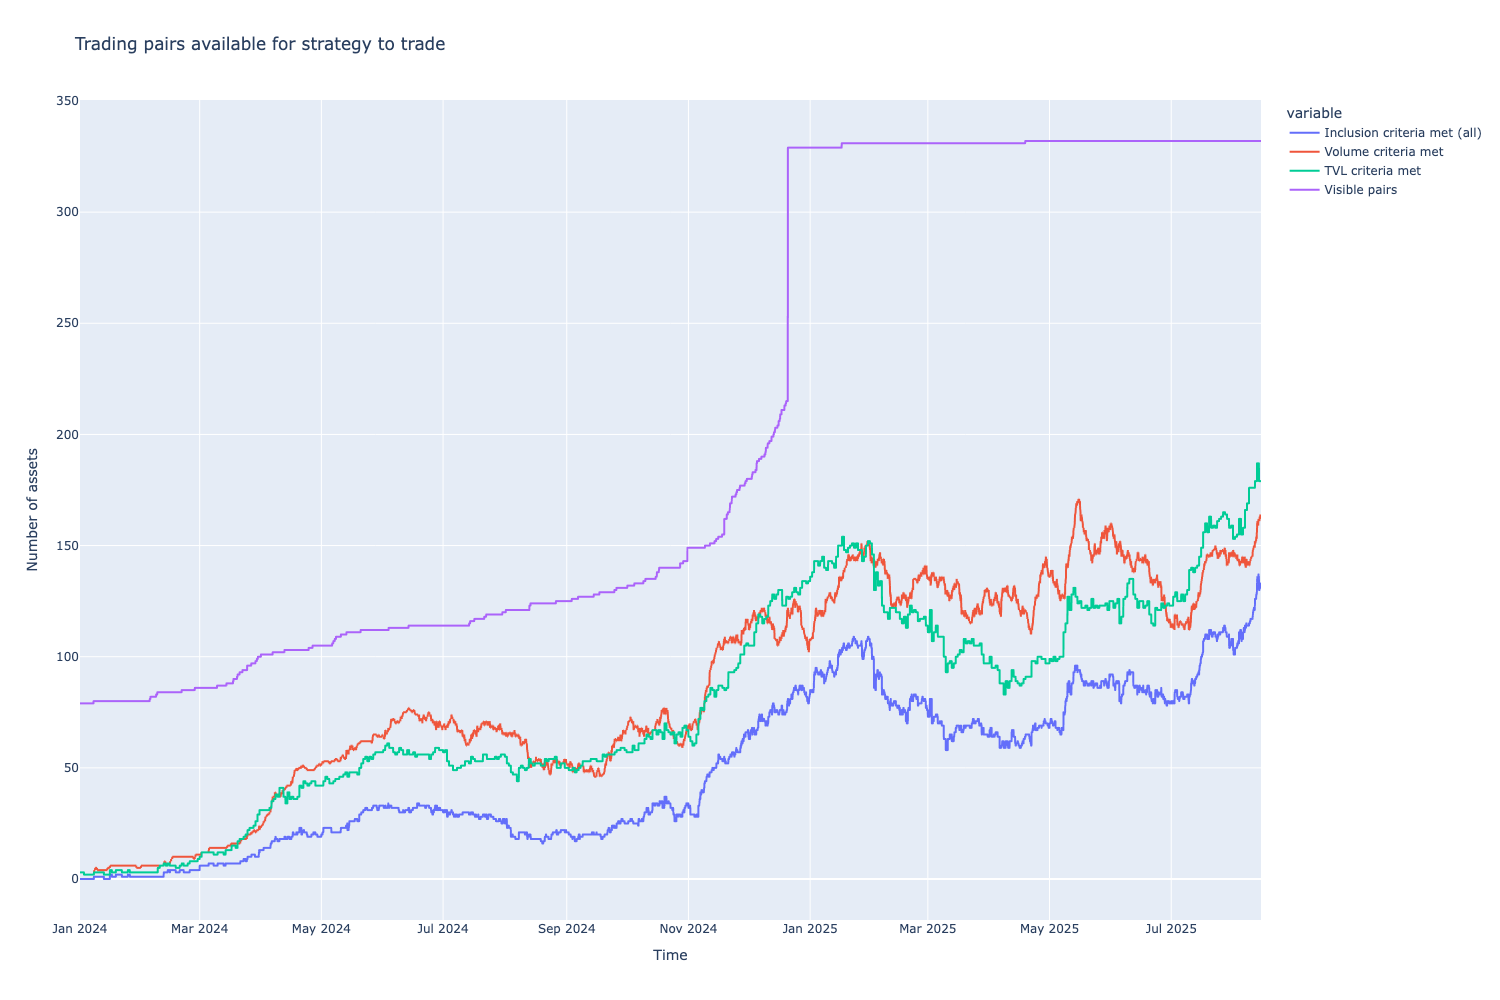

Inclusion criteria met (all)  Volume criteria met  \
2025-08-14 20:00:00                           132                163.0   
2025-08-14 21:00:00                           131                162.0   
2025-08-14 22:00:00                           132                164.0   
2025-08-14 23:00:00                           132                164.0   
2025-08-15 00:00:00                           133                163.0   

                     TVL criteria met  Visible pairs  
2025-08-14 20:00:00               179            332  
2025-08-14 21:00:00               179            332  
2025-08-14 22:00:00               179            332  
2025-08-14 23:00:00               179            332  
2025-08-15 00:00:00               179            332

In [8]:
fig, df = chart_renderer.render(available_trading_pairs, with_dataframe=True)
fig.show()
display(df.tail(5))

## Inclusion criteria checks

- Examine when different pairs got included and what was the pair status during the inclusion

In [9]:
from tradingstrategy.liquidity import LiquidityDataUnavailable

df = chart_renderer.render(inclusion_criteria_check)

print(f"First appearances of {len(df)} trading pairs, when they meet all inclusion criteria:")

with pd.option_context("display.float_format", "{:,.2f}".format):
    display(df.head(5))


First appearances of 254 trading pairs, when they meet all inclusion criteria:


Included at        Ticker         DEX  TVL at inclusion  \
4564367 2024-01-08 00:00:00     WETH-USDC  uniswap-v3        171,147.79   
4569519 2024-01-16 00:00:00    DEGEN-WETH  uniswap-v3        201,146.41   
4568627 2024-01-25 00:00:00    TOSHI-WETH  uniswap-v3        188,002.24   
4570565 2024-02-11 22:00:00  doginme-WETH  uniswap-v3        194,120.69   
4571346 2024-02-15 03:00:00   CIRCLE-WETH  uniswap-v3        964,987.21   

           TVL at end Rolling volume first entry at  Rolling volume initial  
4564367 30,550,145.95           2024-01-01 00:00:00            3,070,596.06  
4569519    730,405.36           2024-01-07 19:00:00              364,959.25  
4568627  3,518,660.12           2024-01-01 00:00:00            1,099,692.91  
4570565  3,274,092.79           2024-02-04 23:00:00            5,389,890.60  
4571346    441,985.94           2024-02-08 04:00:00           15,751,879.30

# Signal across pairs

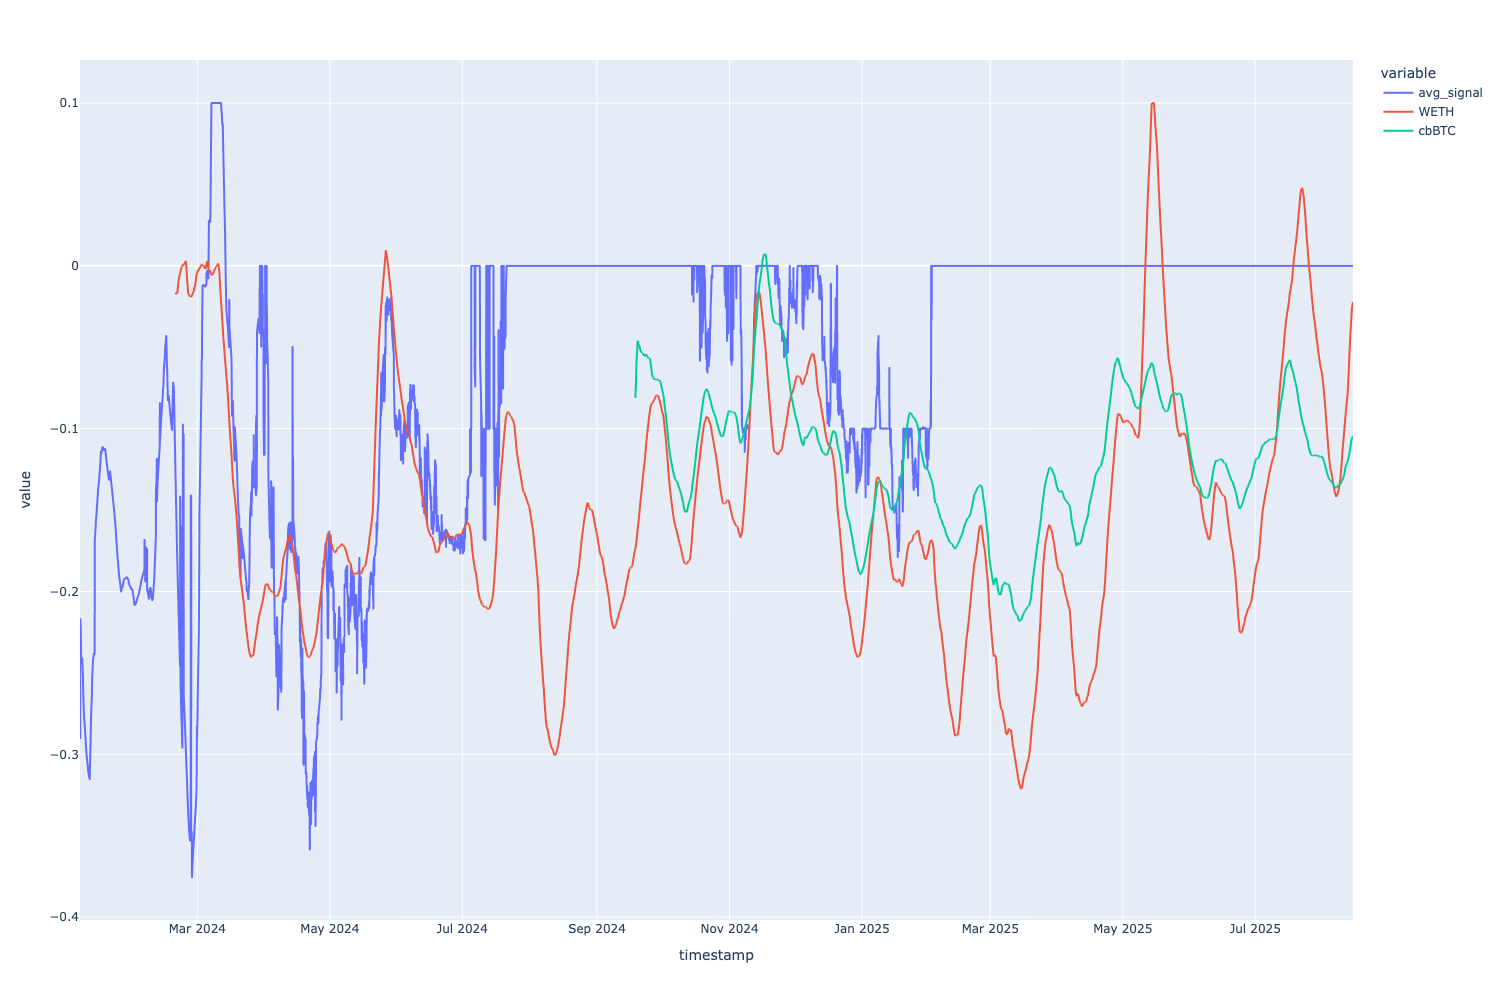

In [10]:
fig = chart_renderer.render(signal_comparison)
fig.show()

# Price vs. signal

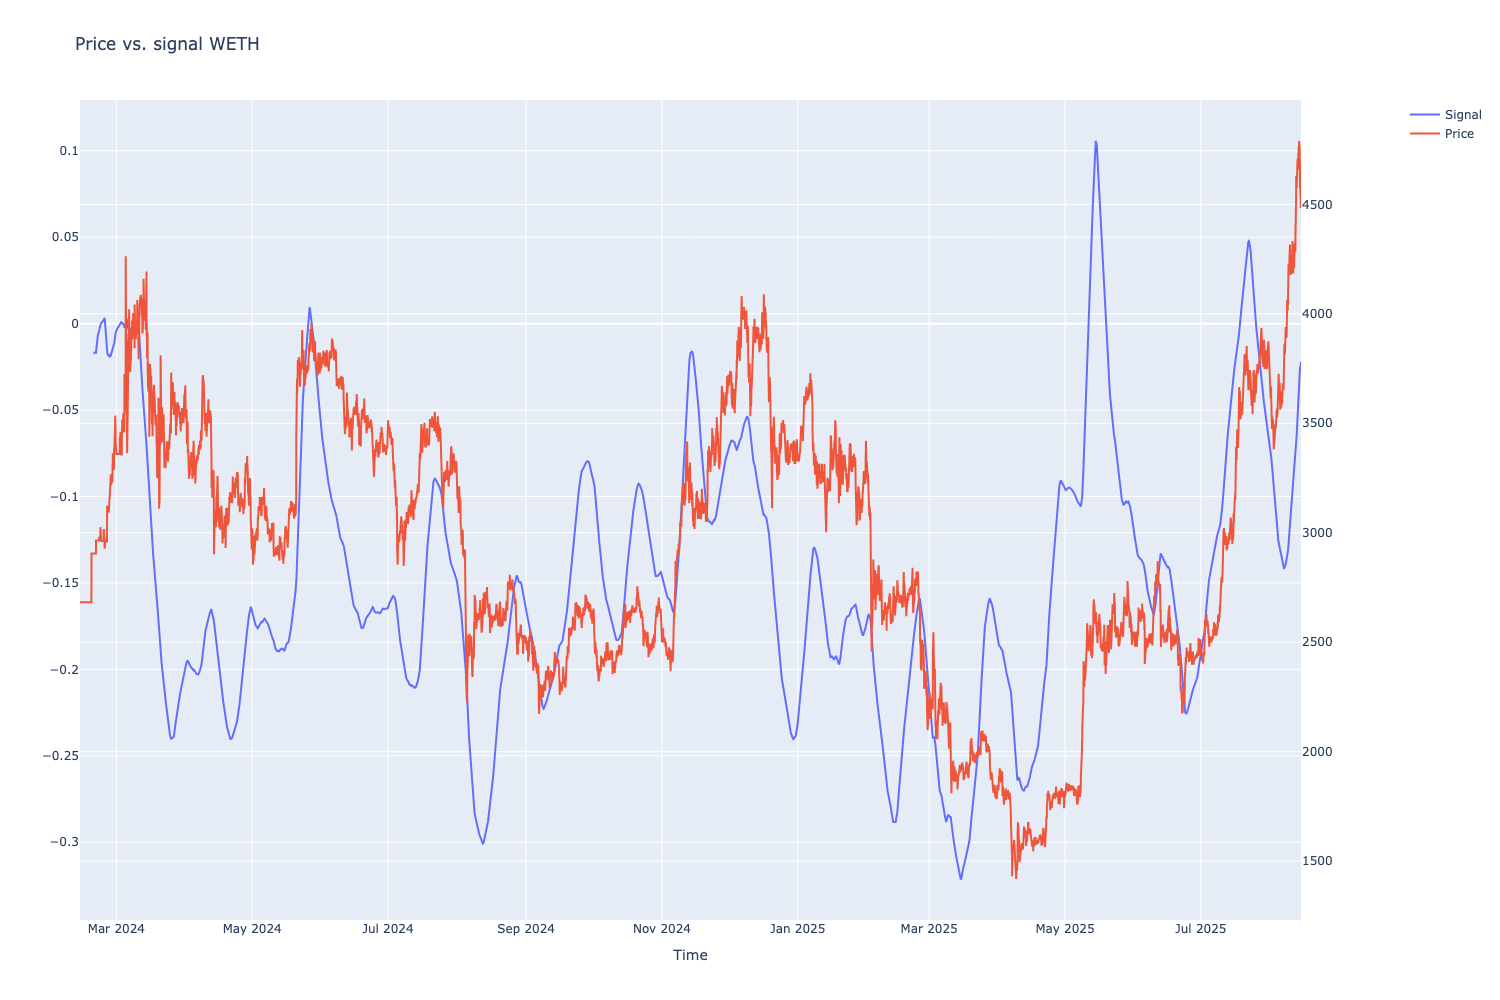

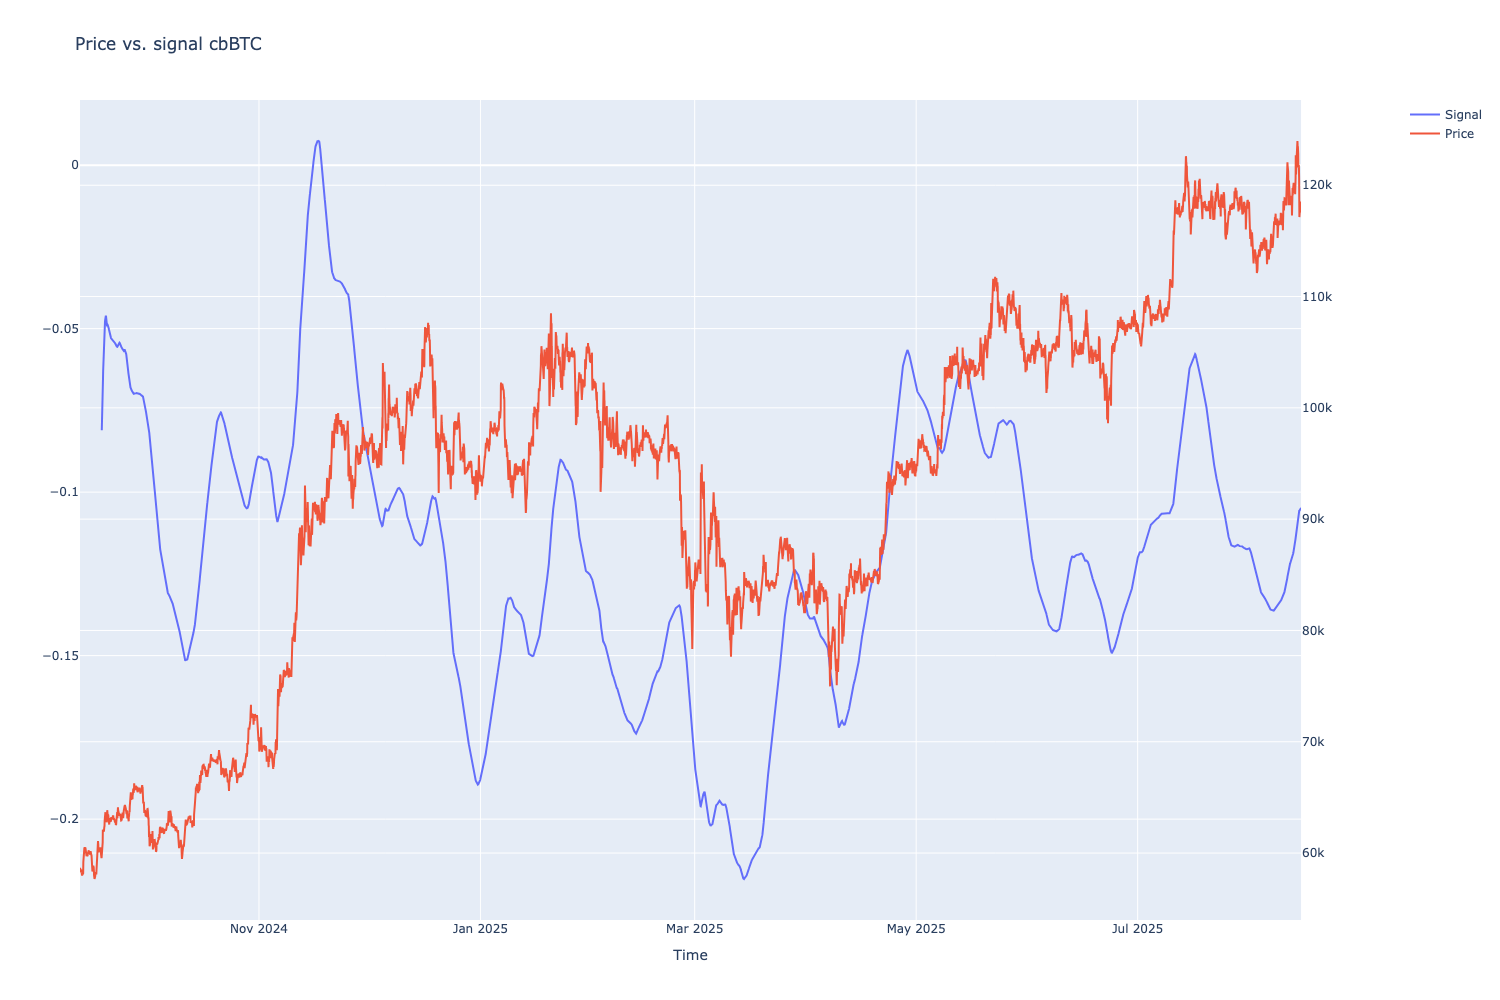

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

for fig in chart_renderer.render(price_vs_signal):
    fig.show()
    

# Price vs. ATH indicator

- Plot ATH indicator

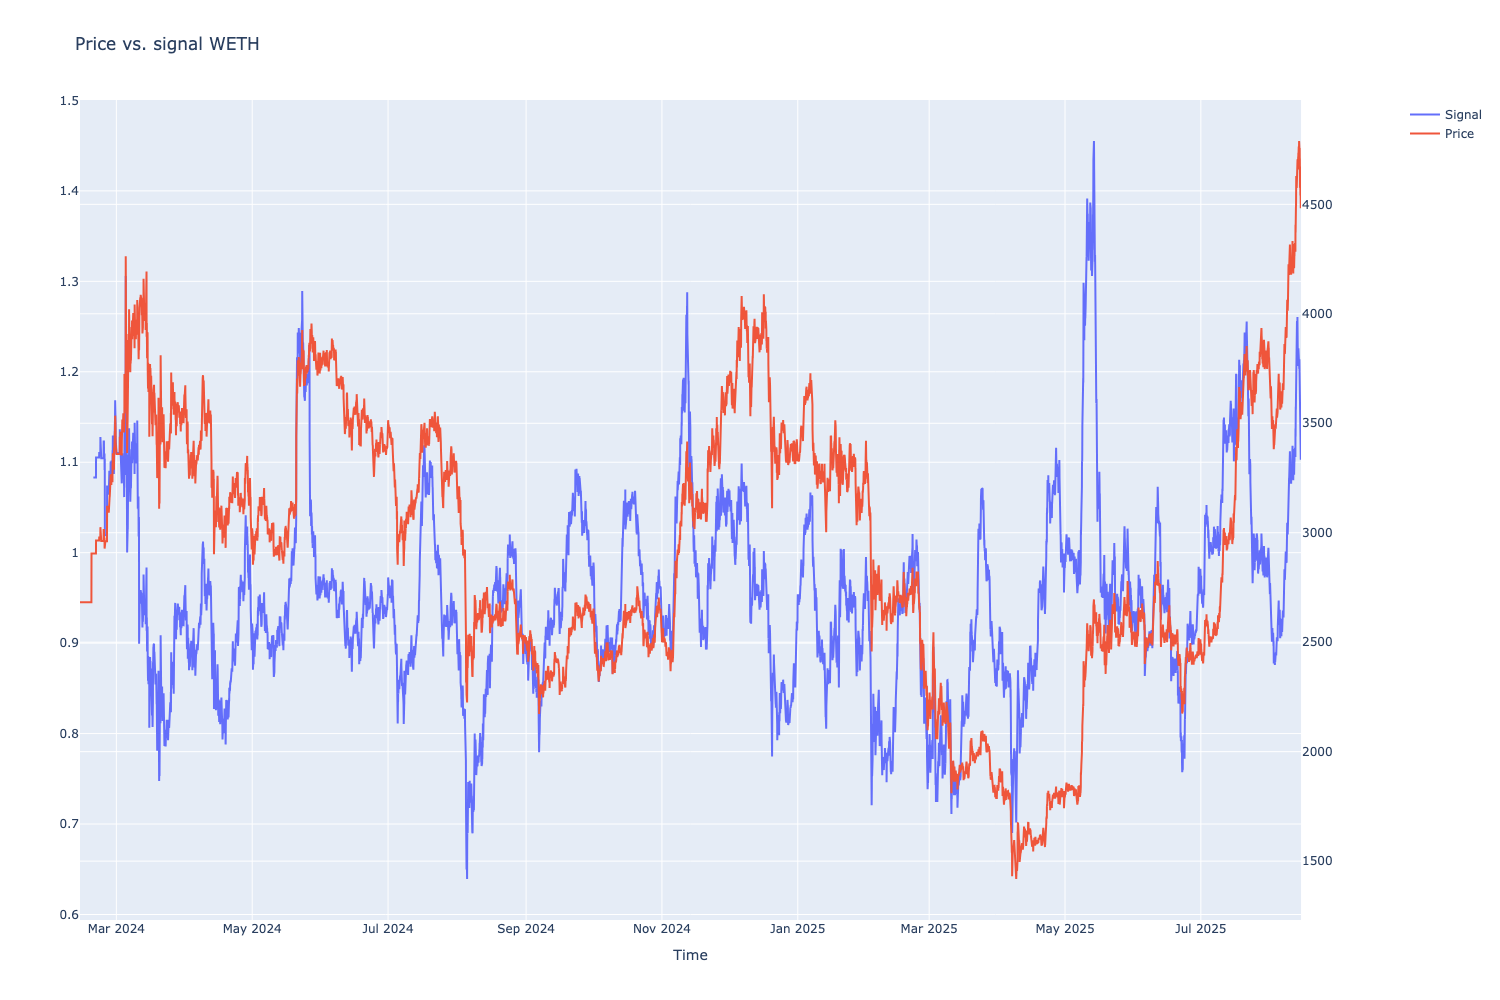

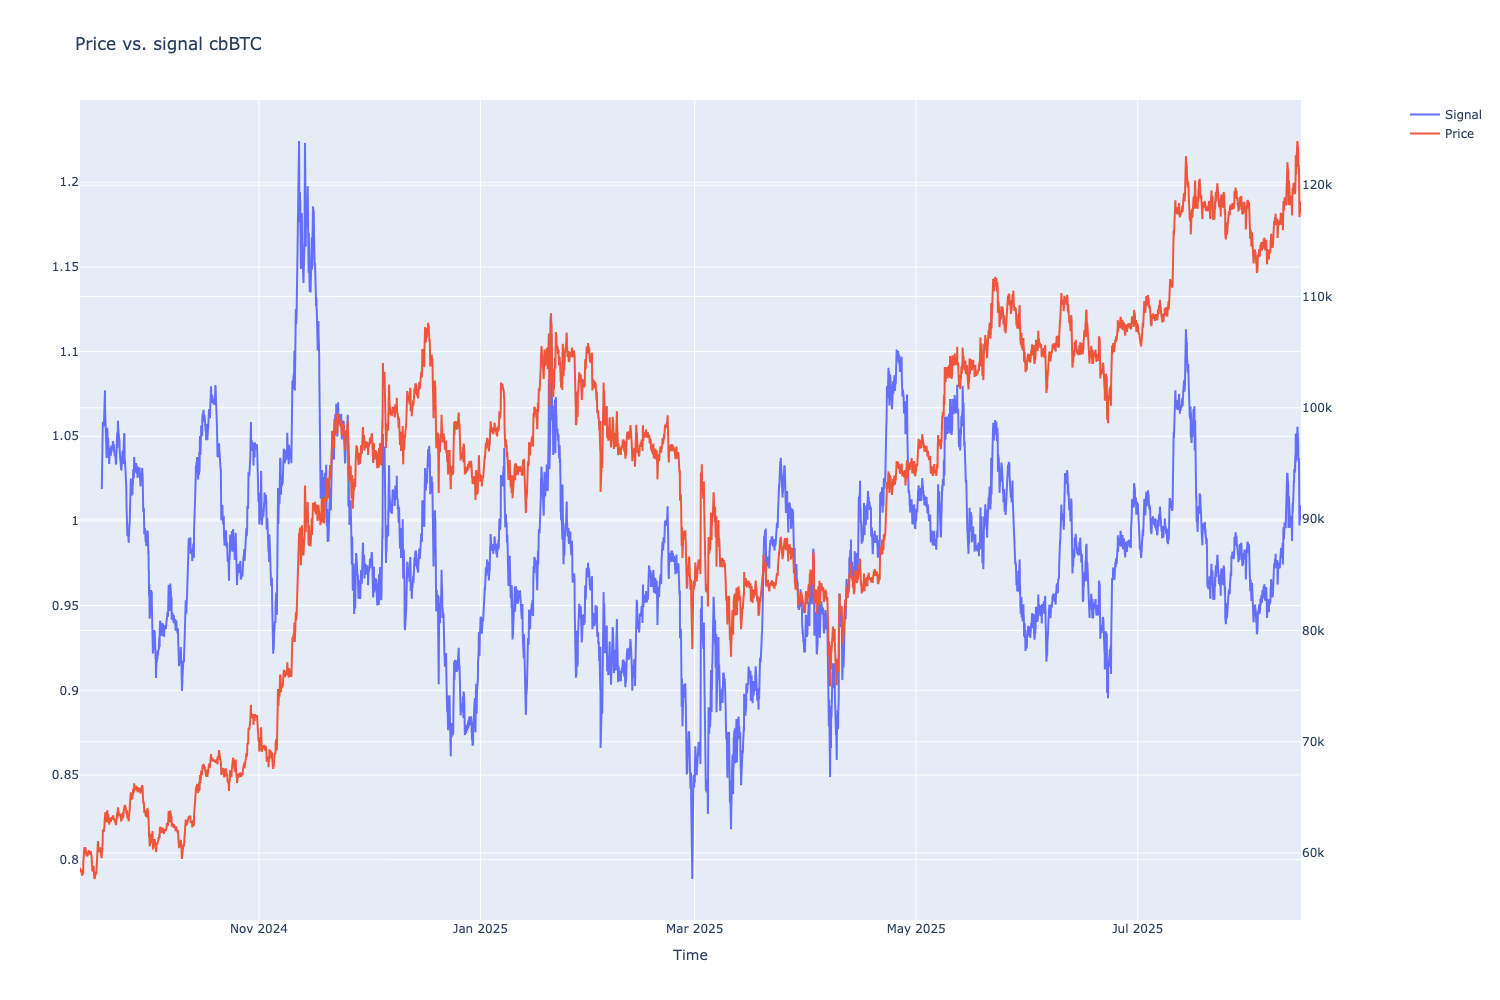

In [12]:
for fig in chart_renderer.render(ath_chart):
    fig.show()
    

# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [13]:
series = indicator_data.get_indicator_series("all_criteria_included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = Parameters.backtest_start
backtest_end = Parameters.backtest_end

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2024-01-01 00:00:00 - 2025-08-15 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [14]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any
from tradeexecutor.strategy.pandas_trader.yield_manager import YieldManager, YieldRuleset, YieldWeightingRule, YieldDecisionInput


def create_yield_rules(
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
) -> YieldRuleset:
    """Create yield rules for the strategy."""

    aave_usdc = strategy_universe.get_credit_supply_pair()
    ipor_usdc = strategy_universe.get_pair_by_smart_contract(VAULTS[0][1])
    maxapy_usdc = strategy_universe.get_pair_by_smart_contract(VAULTS[1][1])
    morpho_flagship = strategy_universe.get_pair_by_smart_contract(VAULTS[2][1])
    spark = strategy_universe.get_pair_by_smart_contract(VAULTS[3][1])

    # Check we have yield vault metadata loaded
    assert aave_usdc
    assert ipor_usdc
    assert maxapy_usdc
    assert morpho_flagship
    assert spark

    return YieldRuleset(
        position_allocation=parameters.allocation,
        buffer_pct=parameters.directional_trade_yield_buffer_pct,
        cash_change_tolerance_usd=parameters.yield_flow_dust_threshold,
        weights=[
            YieldWeightingRule(
                pair=maxapy_usdc, 
                max_concentration=0.75,
                max_pool_participation=0.05,
            ),
            YieldWeightingRule(
                pair=ipor_usdc, 
                max_concentration=0.75,
                max_pool_participation=0.05,    
            ),
            YieldWeightingRule(
                pair=morpho_flagship, 
                max_concentration=0.75,
                max_pool_participation=0.25,    
            ),

            YieldWeightingRule(
                pair=spark, 
                max_concentration=0.75,
                max_pool_participation=0.25,    
            ),

            YieldWeightingRule(pair=aave_usdc, max_concentration=1.0),
        ]
    )


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe
    cycle = input.cycle
    execution_context = input.execution_context

    # Build signals for each pair
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    volume_included_pair_count = indicators.get_indicator_value(
        "volume_included_pair_count",
    )
    tvl_included_pair_count = indicators.get_indicator_value(
        "tvl_included_pair_count",
    )

    # Get pairs included in this rebalance cycle.
    # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []

    # Set signal for each pair
    signal_count = 0
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        assert pair.is_spot() and not pair.is_vault(), "Signal-based weighting should be only used for directional positions"

        pair_signal = indicators.get_indicator_value("signal", pair=pair)
        if pair_signal is None:
            continue

        weight = pair_signal

        if weight < 0:
            continue

        # Live trading/backtesting difference debugging
        state.other_data.save(cycle, f"weight_{pair.get_ticker()}", weight)

        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1

    # Live trading/backtesting difference debugging
    state.other_data.save(cycle, f"signal_count", signal_count)

    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    equity = portfolio.get_total_equity()
    portfolio_target_value = equity * parameters.allocation

    if not execution_context.live_trading:
        # In backtesting, we do not want to blow up the portfolio if something goes wrong,
        # so we put some safety checks here.
        assert equity > 80_000, f"Trapped bad unit test run, portfolio value should not fall this low: {equity}"

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_passthrouh)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    #
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=0.0,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)

    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd

    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        sell_rebalance_min_threshold=parameters.sell_rebalance_min_threshold,
        execution_context=input.execution_context,
    )

    # Live trading/backtesting difference debugging
    state.other_data.save(cycle, f"rebalance_trade_count", len(trades))

    # Move cash in and out yield managed to cover spot positions
    if parameters.use_managed_yield:
        yield_manager = YieldManager(
            position_manager=position_manager,
            rules=create_yield_rules(parameters, strategy_universe), 
        )

        yield_input = YieldDecisionInput(
            execution_mode=input.execution_context.mode,
            cycle=input.cycle,
            timestamp=timestamp,
            total_equity=state.portfolio.get_total_equity(),
            directional_trades=trades,
            size_risk_model=size_risk_model,
            pending_redemptions=position_manager.get_pending_redemptions(),
        )
        yield_result = yield_manager.calculate_yield_management(yield_input)
        trades += yield_result.trades

    else:
        yield_result = None

    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        rebalance_volume = sum(t.get_value() for t in trades)

        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting volume inclusion criteria: {volume_included_pair_count}
        Pairs meeting TVL inclusion criteria: {tvl_included_pair_count}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Yield flow: {yield_result and yield_result.trade_cash_diff or 0:,.2f} USD
        Yield trades: {yield_result and yield_result.trades or '-'}
        Rebalance volume: {rebalance_volume:,.2f} USD
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal value: {top_signal.signal}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report,
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)

    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start,
    end_at=backtest_end,
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

# Add state to the further charts
chart_renderer = ChartBacktestRenderingSetup(
    registry=charts,
    strategy_input_indicators=indicator_data,
    state=state,
)

Reading cached indicators local_ath, full_history_ath, volatility, rolling_cumulative_volume, rolling_liquidit…

Using indicator cache /Users/moo/.cache/indicators/base_1h_335_2024-01-01-2025-08-15_ff


  0%|          | 0/51148800 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 11833 trades


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [15]:
df = chart_renderer.render(performance_metrics)
display(df)

Strategy                cbBTC  \
Start Period                        2024-01-01           2024-01-01   
End Period                          2025-08-14           2025-08-14   
Risk-Free Rate                            0.0%                 0.0%   
Time in Market                          100.0%                56.0%   
Cumulative Return                      598.36%               106.3%   
CAGR﹪                                  129.04%               36.18%   
Sharpe                                    4.23                  1.5   
Prob. Sharpe Ratio                      100.0%               97.45%   
Smart Sharpe                              3.86                 1.44   
Sortino                                  13.68                 2.42   
Smart Sortino                            12.49                 2.32   
Sortino/√2                                9.67                 1.71   
Smart Sortino/√2                          8.83                 1.64   
Omega                                     2.93                 2.28   
Max Drawdown                            -5.21%              -27.96%   
Longest DD Days                            156                  153   
Volatility (ann.)                       29.35%               33.56%   
Calmar                                   24.78                 1.29   
Skew                                       3.9                 0.68   
Kurtosis                                 22.56                 5.78   
Expected Daily                           0.33%                0.12%   
Expected Monthly                        10.21%                3.69%   
Expected Yearly                        164.27%               43.63%   
Kelly Criterion                         40.96%               15.09%   
Risk of Ruin                              0.0%                 0.0%   
Daily Value-at-Risk                     -2.19%               -2.75%   
Expected Shortfall (cVaR)               -2.19%               -2.75%   
Max Consecutive Wins                        26                    7   
Max Consecutive Losses                       7                    6   
Gain/Pain Ratio                           1.93                 0.34   
Gain/Pain (1M)                            30.3                 3.02   
Payoff Ratio                              1.78                 1.31   
Profit Factor                             2.93                 1.34   
Common Sense Ratio                         8.1                 1.78   
CPC Index                                 3.25                 0.91   
Tail Ratio                                2.76                 1.33   
Outlier Win Ratio                         9.09                 5.87   
Outlier Loss Ratio                        5.02                 2.08   
MTD                                      1.01%                4.63%   
3M                                       1.95%               21.12%   
6M                                       12.0%               26.68%   
YTD                                     34.55%               34.23%   
1Y                                     111.54%               106.3%   
3Y (ann.)                              129.04%               36.18%   
5Y (ann.)                              129.04%               36.18%   
10Y (ann.)                             129.04%               36.18%   
All-time (ann.)                        129.04%               36.18%   
Best Day                                 13.1%               10.48%   
Worst Day                               -3.14%               -7.87%   
Best Month                             136.18%                34.5%   
Worst Month                              -4.6%              -19.71%   
Best Year                              419.05%               53.69%   
Worst Year                              34.55%               34.23%   
Avg. Drawdown                           -1.81%               -4.55%   
Avg. Drawdown Days                          13                   15   
Recovery Factor                          38.67                

# Equity curve

- Equity curve shows how your strategy accrues value over time

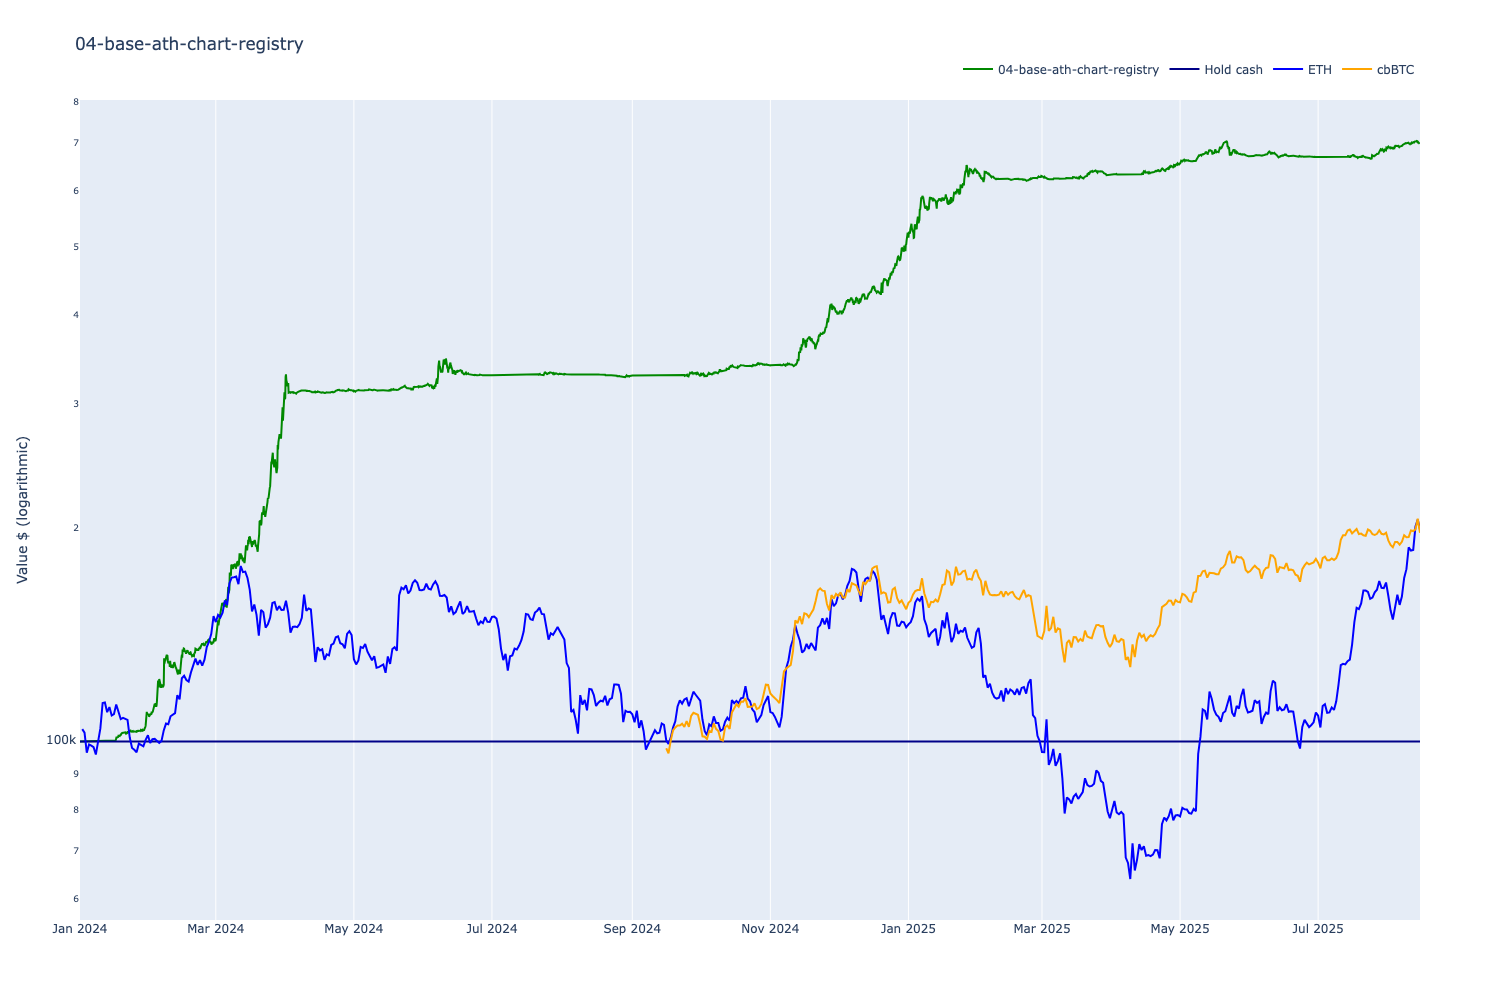

In [16]:
fig = chart_renderer.render(
    equity_curve_with_benchmark, 
)

fig.show()

## Equity curve with drawdown

- Linear curve

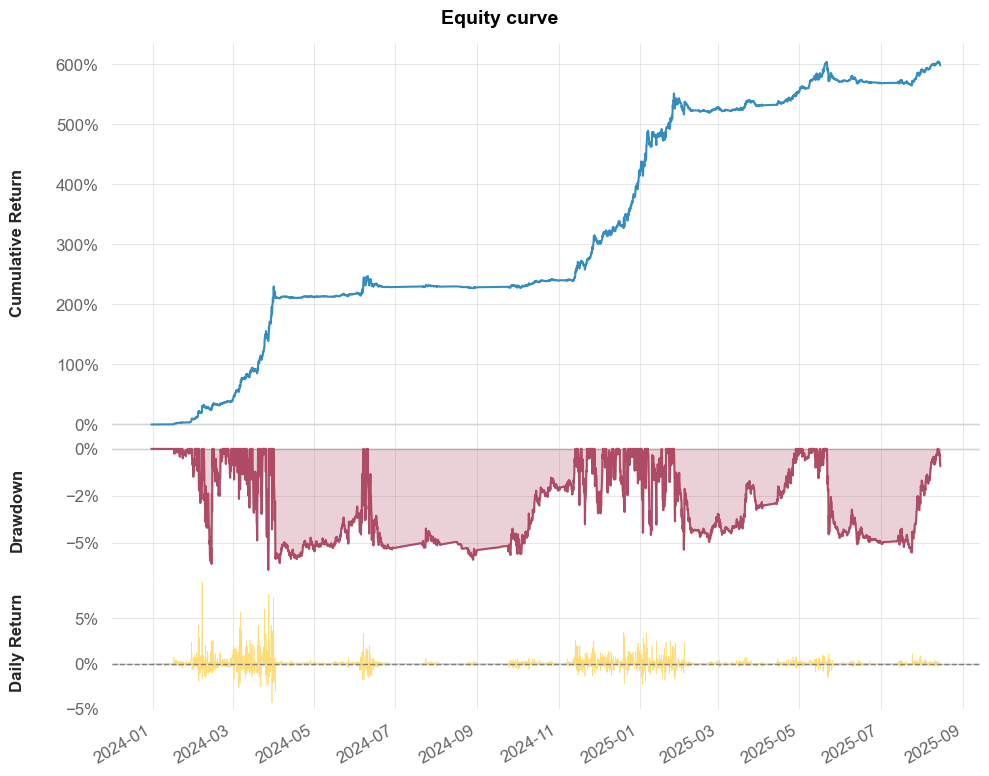

In [17]:
fig = chart_renderer.render(equity_curve_with_drawdown)
fig

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

## Portfolio basket mix

- Different assets hold at different times

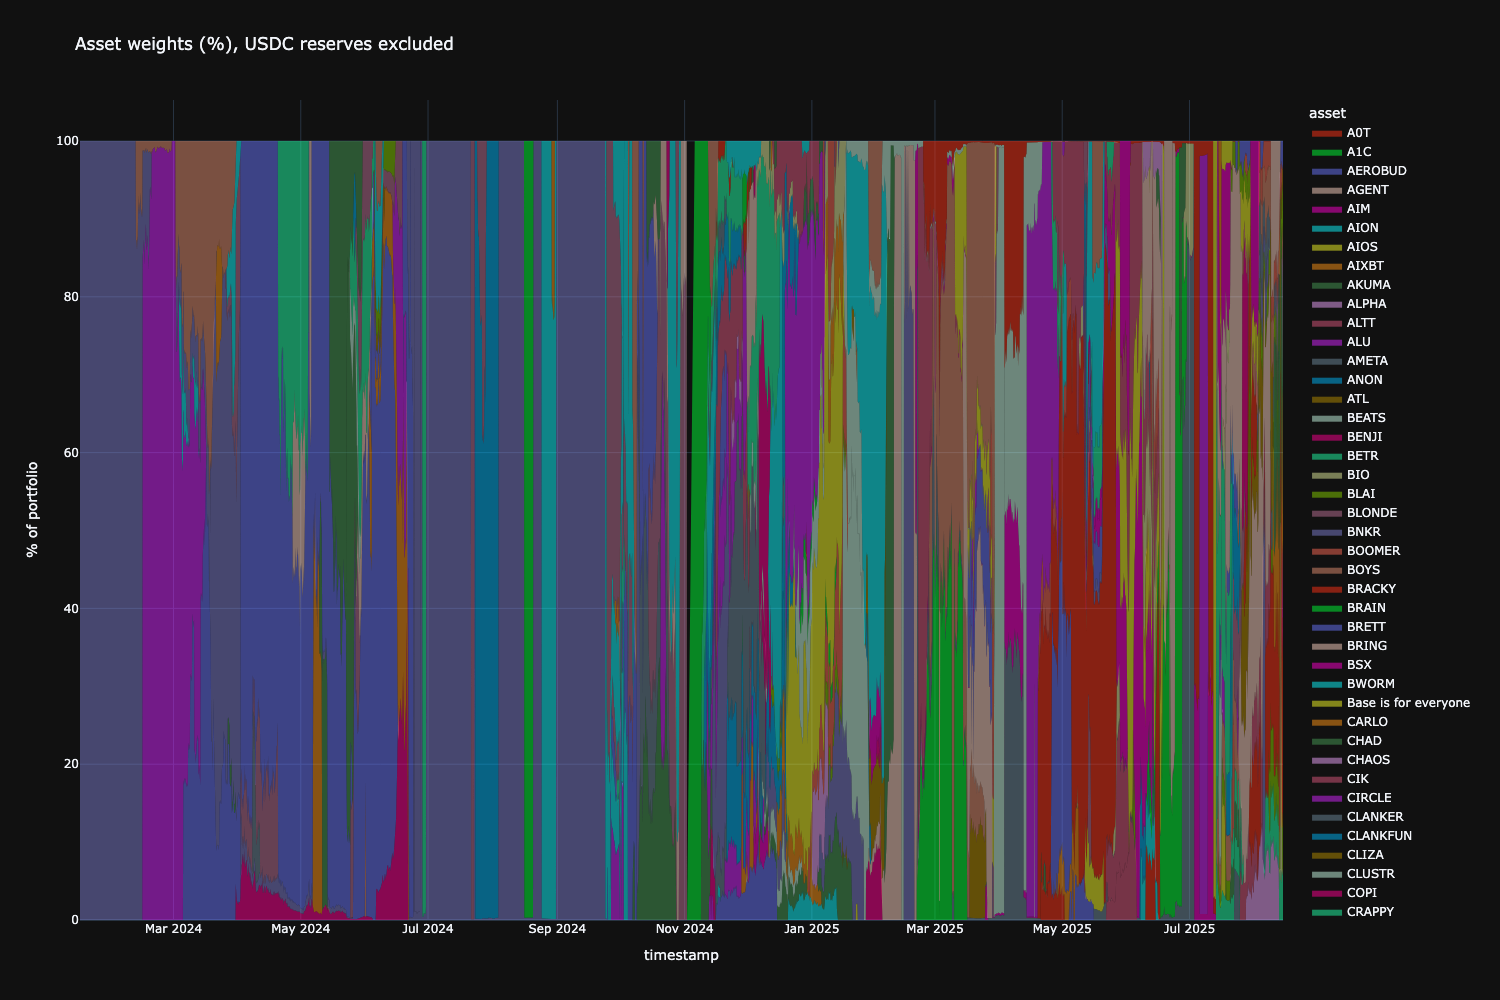

In [18]:
fig = chart_renderer.render(volatile_weights_by_percent)
fig.show()

## Portfolio asset mix with non-volative assets included

- Portfolio with cash, lending and vault positions

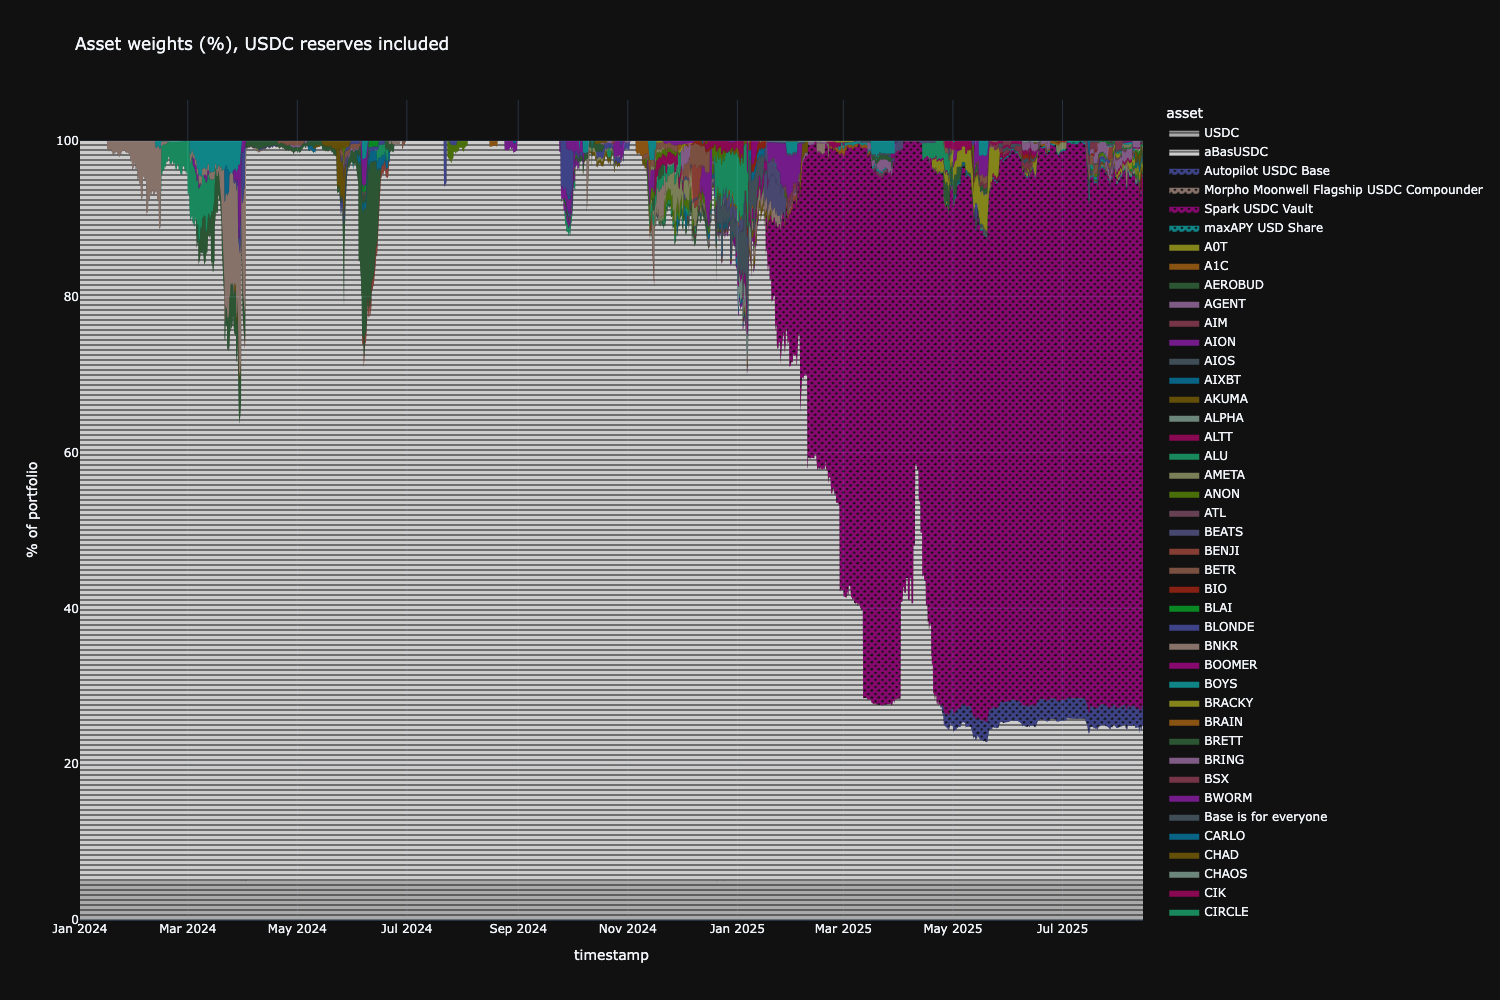

In [19]:

fig = chart_renderer.render(volatile_and_non_volatile_percent)
fig.show()
    

## Portfolio equity curve breakdown by asset

- Where did we make the profit

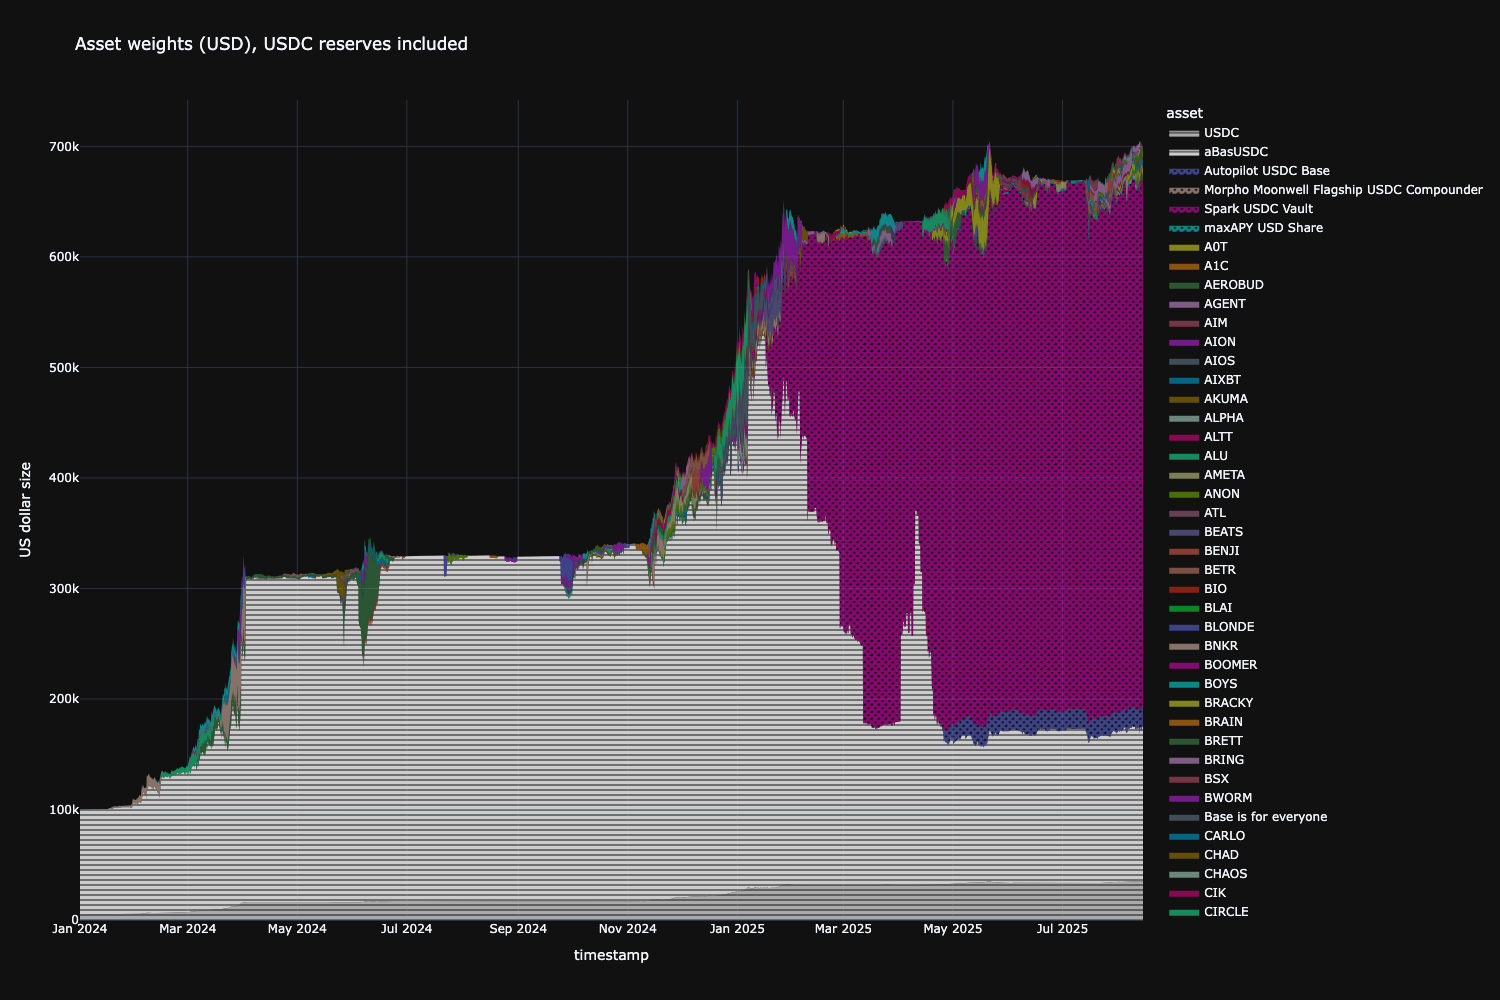

In [20]:
fig = chart_renderer.render(equity_curve_by_asset)
fig.show()

## Weight allocation statistics



In [21]:
stats = chart_renderer.render(weight_allocation_statistics)
display(stats)


At  \
Name                                                  
Max position (excluding USDC)   2025-01-15 16:00:00   
Min position (excluding USDC)   2025-01-25 00:00:00   
Mean position (excluding USDC)                        
Max position (excluding USDC)   2024-01-01 00:00:00   
Min position (excluding USDC)   2025-01-26 16:00:00   
Mean position (excluding USDC)                        
Max position (including USDC)   2024-01-13 12:00:00   
Min position (including USDC)   2025-01-26 16:00:00   
Mean position (including USDC)                        

                                                                    Pair  \
Name                                                                       
Max position (excluding USDC)                                   aBasUSDC   
Min position (excluding USDC)   Morpho Moonwell Flagship USDC Compounder   
Mean position (excluding USDC)                                             
Max position (excluding USDC)                                   aBasUSDC   
Min position (excluding USDC)   Morpho Moonwell Flagship USDC Compounder   
Mean position (excluding USDC)                                             
Max position (including USDC)                                   aBasUSDC   
Min position (including USDC)   Morpho Moonwell Flagship USDC Compounder   
Mean position (including USDC)                                             

                                     Value Unit  
Name                                             
Max position (excluding USDC)   508,567.79  USD  
Min position (excluding USDC)         3.21  USD  
Mean position (excluding USDC)   54,048.00  USD  
Max position (excluding USDC)       100.00    %  
Min position (excluding USDC)         0.00    %  
Mean position (excluding USDC)       13.29    %  
Max position (including USDC)        95.00    %  
Min position (including USDC)         0.00    %  
Mean position (including USDC)       11.73    %

# Alpha model diagnostics data

- Dump out alpha model contents from the last cycle

In [22]:
df = chart_renderer.render(alpha_model_diagnostics)
display(df)

Signal     Asked size  Accepted size  Value adjust USD  \
Pair                                                                        
LOUDER-WETH      0.011283              -            NaN          0.000000   
ICNT-USDC        0.012583              -            NaN          0.000000   
SERV-WETH        0.012906              -            NaN          0.000000   
RUSSELL-WETH     0.035985              -            NaN          0.000000   
PEEZY-WETH       0.044877              -            NaN          0.000000   
VEIL-WETH        0.048490              -            NaN          0.000000   
CHAD-WETH        0.065039              -            NaN          0.000000   
i-WETH           0.065160              -            NaN          0.000000   
KEYCAT-WETH      0.087570              -            NaN          0.000000   
WALLET-WETH      0.095900              -            NaN          0.000000   
PRO-WETH         0.111799              -            NaN          0.000000   
DIME-WETH        0.116371              -            NaN          0.000000   
SPORT-WETH       0.117879              -            NaN          0.000000   
BIO-WETH         0.148042              -            NaN          0.000000   
deai-WETH        0.166061              -            NaN          0.000000   
Clankermon-WETH  0.192497              -            NaN          0.000000   
NET-WETH         0.262169   42246.466616    1711.910229        540.823388   
BSX-WETH         0.263618   41137.421865    2643.817213        498.094415   
horse-WETH       0.271979     41011.6397    1256.100009        324.877307   
BRACKY-WETH      0.288830   42202.592428    6873.481512        251.715376   
IACS-USDC        0.373218   52019.021748    1105.461405        317.591205   
BLAI-USDC        0.479562   62986.799592    2234.133629        275.293172   
FAIR-WETH        0.529823   65383.071875    5393.107001        919.521410   
BETR-WETH        0.552301   63666.577592    2212.814737        476.546362   
Wankr-WETH       2.211470  113772.760378     948.971980        135.670877   
FLOPS-WETH       2.325548   99521.135226    4510.300880       -173.494357   

                 Weights (raw)  Weights (norm/cap)  Old weight      Flipping  \
Pair                                                                           
LOUDER-WETH           0.000000            0.000000    0.000000  none -> spot   
ICNT-USDC             0.000000            0.000000    0.000000  none -> spot   
SERV-WETH             0.000000            0.000000    0.000000  none -> spot   
RUSSELL-WETH          0.000000            0.000000    0.000000  none -> spot   
PEEZY-WETH            0.000000            0.000000    0.000000  none -> spot   
VEIL-WETH             0.000000            0.000000    0.000000  none -> spot   
CHAD-WETH             0.000000            0.000000    0.000000  none -> spot   
i-WETH                0.000000            0.000000    0.000000  none -> spot   
KEYCAT-WETH           0.000000            0.000000    0.000000  none -> spot   
WALLET-WETH           0.000000            0.000000    0.000000  none -> spot   
PRO-WETH              0.000000            0.000000    0.000000  none -> spot   
DIME-WETH             0.000000            0.000000    0.000000  none -> spot   
SPORT-WETH            0.000000            0.000000    0.000000  none -> spot   
BIO-WETH              0.000000            0.000000    0.000000  none -> spot   
deai-WETH             0.000000            0.000000    0.000000  none -> spot   
Clankermon-WETH       0.000000            0.000000    0.000000  none -> spot   
NET-WETH              0.262169            0.059256    0.001766       no flip   
BSX-WETH              0.263618            0.091513    0.003235       no flip   
horse-WETH            0.271979            0.043479    0.001404       no flip   
BRACKY-WETH           0.288830            0.237918    0.009983       no flip   
IACS-USDC             0.373218            0.038264    0.001188       no flip   
BLAI-USDC             

# Trading pair breakdown

- Trade success for each trading pair



In [23]:
html = chart_renderer.render(trading_pair_breakdown, limit=5)
display(html)

# Trading metrics

- Trading cost, etc.

In [24]:
df = chart_renderer.render(trading_metrics)
display(df)


0
Trading period length                       591 days 20 hours
Trading start                                            None
Trading end                                              None
Return %                                              598.36%
Annualised return %                                   369.03%
Cash at start                                     $100,000.00
Value at end                                      $698,363.58
Time in market                                          0.00%
Time in market volatile                                 0.00%
Trade volume                                   $10,510,367.00
Trade volume, no vault                      $1,311,167,170.43
Trade volume, taxed tokens                          $1,816.27
Token tax paid                                        $301.54
Position win percent                                    5.72%
Total positions                                          3058
Won positions                                             175
Lost positions                                            240
Stop losses triggered                                       0
Stop loss % of all                                      0.00%
Winning stop losses                                         0
Winning stop losses percent                                 -
Losing stop losses                                          0
Losing stop losses percent                                  -
Take profits triggered                                      0
Take profit % of all                                    0.00%
Take profit % of won                                    0.00%
Zero profit positions                                       0
Positions open at the end                                  17
Realised profit and loss                          $586,690.01
Unrealised profit and loss                          $4,833.11
Portfolio unrealised value                        $663,442.19
Extra returns on lending pool interest                  $0.00
Cash left at the end                               $34,921.40
Average winning position profit %                      26.93%
Average losing position loss %                        -11.13%
Biggest winning position %                            162.91%
Biggest losing position %                             -48.56%
Average duration of winning positions         11 days 4 hours
Average duration of losing positions           3 days 7 hours
Average duration between position openings  0 hours 0 minutes
Average positions per day                                5.17
Average interest paid                                   $0.00
Median interest paid                                    $0.00
Total interest paid                                     $0.00
LP fees paid                                       $76,767.45
LP fees paid % of volume                                0.73%
LP fees paid, no vault                             $76,767.45
LP fees paid % of volume, no vault                      0.01%
Average position                                        4.92%
Median position                                        -2.24%
Most consecutive wins                                       9
Most consecutive losses                                    14
Biggest realised risk                                  -2.75%
Avg realised risk                                      -0.14%
Max pullback of total capital                          -3.27%
Max loss risk at opening of position                   95.00%

# Interest accrued

- How much profit our non-volatile positions generated

## Lending pools

- Calculate interest from lending pools (Aave, etc)

In [25]:
df = chart_renderer.render(lending_pool_interest_accrued)
display(df)

Value
Name                                              
Position count                                2644
Total interest earned                26,194.90 USD
Avg interest                                 6.42%
Min interest                                 0.00%
Max interest                                40.67%
Avg credit position duration        5:22:25.234493
Total deposit flow in         1,302,642,030.80 USD
Min deposit                          94,206.40 USD
Avg deposit                         246,385.86 USD
Max deposit                         508,584.00 USD

# Vault performance

- Analyse the performance of our vaults

## Vault statistics 

- Calculate interest accrued on different vaults for the strategy

In [26]:
df = chart_renderer.render(vault_statistics)
display(df)

Value
Name                                            
Position count                                 4
Total interest earned               4,675.17 USD
Avg interest                               0.73%
Min interest                               0.54%
Max interest                               1.18%
Avg credit position duration  177 days, 21:00:00
Total deposit flow in           1,238,678.88 USD
Min deposit                             5.02 USD
Avg deposit                         2,538.28 USD
Max deposit                        75,013.65 USD

# Examine single pair

- Show trades taken against a single pair

We have total 55 trades on <Pair AIXBT-USDC spot_market_hold at 0xf1fdc83c3a336bdbdc9fb06e318b08eaddc82ff4 (0.3000% fee) on exchange uniswap-v3>


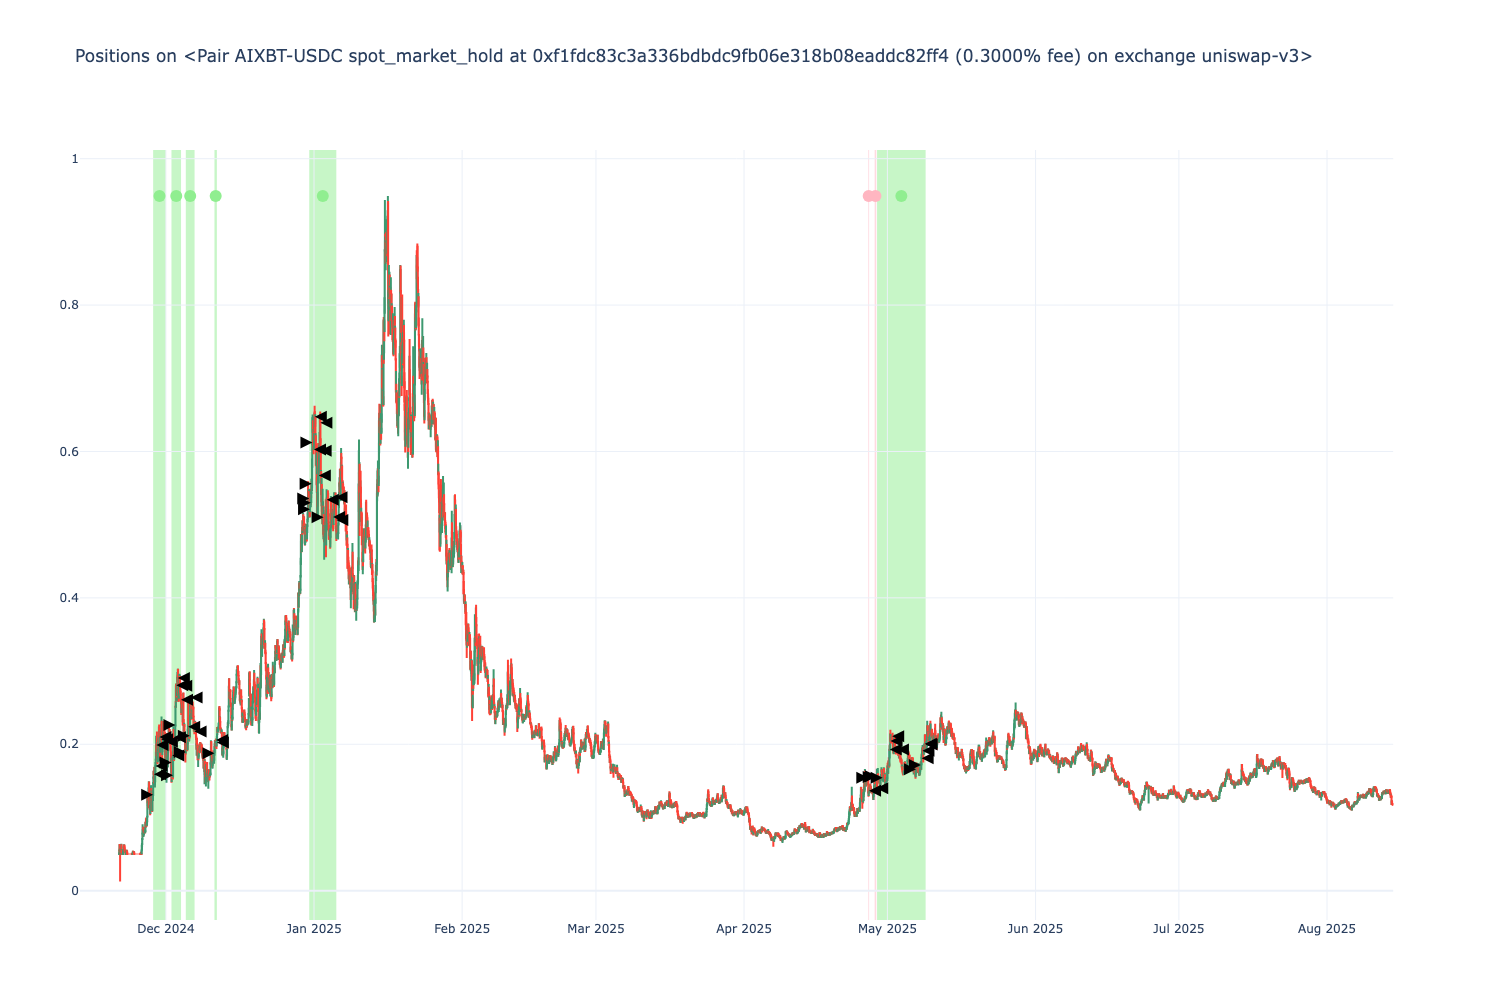

In [27]:
from tradeexecutor.visual.single_pair import visualise_single_pair_positions_with_duration_and_slippage

pair = token_map["AIXBT"]  # Get previously resolved trading pair

all_trades = [t for t in state.portfolio.get_all_trades() if t.pair == pair]
print(f"We have total {len(all_trades)} trades on {pair}")

# start = datetime.datetime(2023, 2, 1)
# end = datetime.datetime(2023, 4, 1)

start = None
end = None

signal = indicator_data.get_indicator_series("signal", pair=pair)

figure = visualise_single_pair_positions_with_duration_and_slippage(
    state=state,
    candles=strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id),
    pair_id=pair.internal_id,
    execution_context=notebook_execution_context,
    title=f"Positions on {pair}",
    start_at=start,
    end_at=end,
)


figure.show()

## Examine positions

In [28]:
from tradeexecutor.visual.single_pair import display_positions_table
display_positions_table(state, pair, sort_by="PnL USD", ascending=True)

Close         Duration      PnL %  \
Open                                                                  
2025-04-28 08:00:00 2025-04-28 16:00:00  0 days 08:00:00  -9.849991   
2025-04-27 00:00:00 2025-04-27 04:00:00  0 days 04:00:00 -11.466947   
2024-12-11 04:00:00 2024-12-11 16:00:00  0 days 12:00:00   8.107374   
2024-12-05 04:00:00 2024-12-07 00:00:00  1 days 20:00:00  14.781073   
2024-12-31 00:00:00 2025-01-05 16:00:00  5 days 16:00:00   3.992073   
2025-04-28 20:00:00 2025-05-09 00:00:00 10 days 04:00:00  23.429855   
2024-12-02 04:00:00 2024-12-04 04:00:00  2 days 00:00:00  40.276043   
2024-11-28 08:00:00 2024-12-01 00:00:00  2 days 16:00:00  46.039072   

                         PnL USD  Trades  
Open                                      
2025-04-28 08:00:00  -147.346526       2  
2025-04-27 00:00:00   -95.748594       2  
2024-12-11 04:00:00   115.458099       3  
2024-12-05 04:00:00   220.906646       5  
2024-12-31 00:00:00   257.760079      15  
2025-04-28 20:00:00   892.389418      12  
2024-12-02 04:00:00  3302.642838       9  
2024-11-28 08:00:00  3508.611947       7